# 2021 금융 데이터 경진대회

# 주제 : K Means Clustering을 활용한 동학개미운동 기간 신규고객의 매매패턴별 군집화 비교 분석 및 유형별 관심 종목 도출 - 임효정

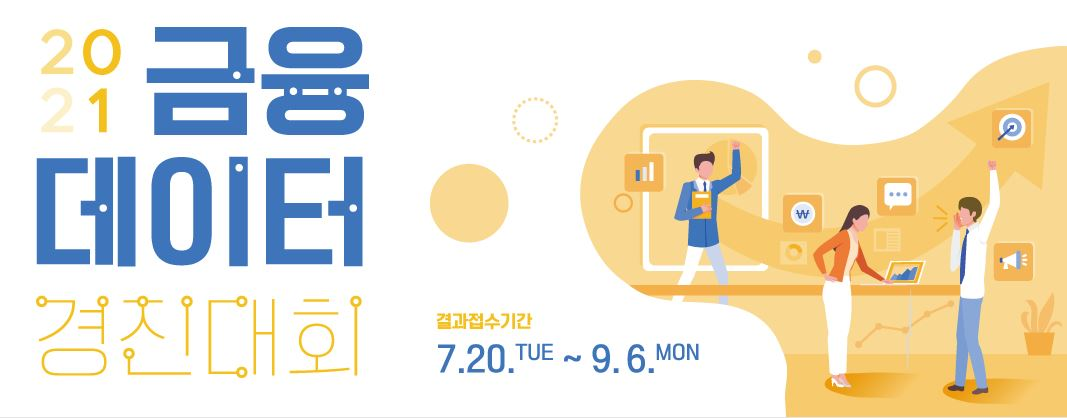

# 배경 및 필요성 
코로나19 이후 '뉴 노멀(New Normal)'이라는 용어가 자주 등장하고 있다. 뉴 노멀이란 어떤 위기가 도래하였을 때 그 이전과 달라지는 사회/경제적 상황 및 새로운 삶의 패턴을 의미한다. 특히 '포스트 코로나19' 시대에서 주식시장의 변동성 또한 강해지면서 이러한 변화에 대응할 필요성이 더욱 대두되고 있다. <br>
따라서 본 과제에서는 한국투자증권에서 제공한 '동학개미운동 신규 고객 투자 정보' 데이터를 활용하여 코로나19 발발이 시작되어 변동성이 심했던 동학개미운동(20.01.20~20.03.31) 기간 사이의 신규 고객의 특성과 매매패턴을 분석하고, 그 결과를 바탕으로 비슷한 특성의 고객끼리 군집화를 진행하여 군집별 비교 및 각 군집에서 관심을 갖는 종목과 산업을 분석하고자 한다.<br>
특히 급변하는 포스트 코로나19 시대에서 비슷한 특성과 매매패턴을 보이는 고객들을 개별 군집으로 분류하여 분석한다면, 변동성을 예측하는 것은 물론 해당 군집들이 선호하는 종목과 산업을 통하여 새로운 미래에 대비할 수 있는 기회가 될 것이라고 판단된다.

# 가설 
COVID-19 확진자수 추세에 따라 시장에서 관심을 갖는 업종이 달라질 것이며 이에 대한 대응은 투자자의 성향에 따라서도 달라질 것이다. 따라서 우선적으로 COVID-19 확진자수 추이와 업종별 주가, 거래량의 상관관계를 조사하고 상관관계가 높은 산업들을 포스트 코로나 이후 고객들의 관심 업종으로 도출한다. 또한 동학개미운동 기간동안 가입한 신규고객들의 매매패턴을 고객별 주문횟수, 고개별 주문간격(일자 기준), 고객별 매매종목수, 고객별 총거래액, 고객별 매수액 비중, 고객별 매도액 비중, 고객별 투자 업종 비중, 고객별 투자 기업 종류별 비중 등을 기준으로 파악하고 이러한 매매패턴에 따라 K Means Clustering 방법을 통하여 비슷한 투자 유형을 군집화 한다. 그리고 각 유형의 고객들의 특징을 분석하고 해당 고객들이 관심을 갖는 종목과 산업에 대하여 분석할 것이다.

# 필요한 라이브러리 및 데이터셋 불러오기

In [1]:
pip install plotly --upgrade

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\time2\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np

import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import IFrame

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import os 
import warnings 
warnings.filterwarnings(action = 'ignore') 
pd.options.display.max_columns = None

In [3]:
path = '../findatacontest2021'
kis = pd.read_excel(path + '/dataset/kis_new_invest.xlsx')
kis.head(5)

,고객구분코드,주문일자,고객성별구분코드,동일나이군구분코드,주소(시도),주문시간대,상품번호,상품명,거래소구분코드,매도매수구분코드,주문구분코드,실주문단가,주문수량,총체결수량,총체결금액,전일종가,당일시가,일중고가,일중저가,당일종가,거래수량,거래대금,상한가여부,하한가여부
0,A0001,20200128,1,30,경기,1,00000A091970,나노캠텍,3,2,1,3795,20,20,75900,3215,3710,4125,3660,4095,17266597,67323312855,N,N
1,A0001,20200130,1,30,경기,3,00000A045060,오공,3,2,1,7710,20,20,154200,7690,8150,8380,7360,7920,15686931,125404000000,N,N
2,A0001,20200313,1,30,경기,1,00000A253840,수젠텍,3,2,1,11800,10,10,118000,13600,12200,12250,10150,10750,3731106,40782765600,N,N
3,A00010,20200220,1,20,경남,3,00000A009190,대양금속보통주,2,2,1,3505,14,14,49070,3615,3615,3675,3475,3505,635410,2250893355,N,N
4,A000100,20200211,2,40,서울,1,00000A001740,SK네트웍스보통주,2,1,1,4875,3,3,14625,4780,4800,4885,4800,4850,1263089,6112026870,N,N


# 외부 데이터 추가

## 상장법인 업종 데이터 추가

1. 업종 데이터의 필요성 : 동학개미운동(20.01.20 ~ 20.03.31) 기간 기준 신규고객들의 관심 업종을 탐구하기 위하여 개별 종목의 업종 정보를 추가할 필요성이 있다.

2. 자료 참고 : 한국거래소(KRX)의 업종분류 현황 http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020506 <br>
한국거래소(KRX)의 종목별 업종정보 http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203

In [5]:
# KOSPI와 KOSDAQ 업종을 병합하기 위한 함수 
def new_sector(x:str) -> str:
    if x == '건설':
        return '건설업'
    elif x == '기계':
        return '기계·장비'
    elif x == '기타제조':
        return '기타제조업'
    elif x == '비금속':
        return '비금속광물'
    elif x == '섬유·의류':
        return '섬유의복'
    elif x == '운송':
        return '운수창고업'
    elif x == '운송장비·부품':
        return '운수장비'
    elif x == '유통':
        return '유통업'
    elif x == '음식료·담배':
        return '음식료품'
    elif x == '의료·정밀기기':
        return '의료정밀'
    elif x == '제약':
        return '의약품'
    elif x == '일반전기전자':
        return '전기전자'
    elif x == '전기·가스·수도':
        return '전기가스업'
    elif x == '종이·목재':
        return '종이목재'
    elif x == '금속':
        return '철강금속'
    elif x == '통신서비스' or x == '통신장비':
        return '통신업'
    elif x == '기타서비스':
        return '서비스업'
    else:
        return x

In [11]:
# KOSPI의 종목코드별 업종 데이터 불러오기 
kospi_sector = pd.read_csv(path + '/외부데이터/KOSPI 업종 (20200302).csv', encoding = 'cp949')
kospi_sector = kospi_sector[['종목코드', '업종명']]

# KOSDAQ의 종목코드별 업종 데이터 불러오기 
kosdaq_sector = pd.read_csv(path + '/외부데이터/KOSDAQ 업종 (20200302).csv', encoding = 'cp949')
kosdaq_sector = kosdaq_sector[['종목코드', '업종명']]

# KOSPI와 KOSDAQ 업종을 병합하여 업종 분류
sector = pd.concat([kospi_sector, kosdaq_sector])
sector['업종명'] = sector['업종명'].apply(new_sector)

# 매매내역 데이터에 상장법인 종목코드에 따른 업종 데이터 추가 
kis['종목코드'] = kis['상품번호'].apply(lambda x: x[6:])
kis = pd.merge(kis, sector, how = 'left', on = '종목코드')

# KRX 정보데이터시스템의 개별종목 종합정보 조회를 통하여 결측치인 업종 정보 채우기
# 자료 참고 : 종목별 업종정보 http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203
fill_sector = {'제이앤티씨' : 'IT부품', '엔피디' : 'IT부품', '썬테크놀로지스' : '철강금속', '하나금융15호기업인수목적' :'금융', '플레이디' : '서비스업', 
               '켄코아에어로스페이스' : '운수장비', '서울바이오시스' : '반도체'}

for key, value in fill_sector.items():
    kis.loc[kis['상품명'] == key, '업종명'] = value

## 상장법인의 규모 및 재정요건별 분류를 위한 소속부 데이터 추가

1. 상장법인 규모 및 재정요건별 분류의 필요성 : 동학개미운동(20.01.20 ~ 20.03.31) 기간 기준 신규고객들이 투자하는 법인의 규모(자기 자본, 시가총액)와 재무요건 등을 구분하는 분류 작업을 통하여 신규고객이 어떠한 규모의 기업 위주로 투자하는지에 대한 인사이트를 얻을 수 있을 것이다.

2. 상장법인 규모 및 재정요건별 분류의 방법 : 우선 KOSPI에 상장된 기업을 '대형기업'으로 분류한다. KOSDAQ에 상장된 기업의 경우에는 한국거래소에서 매년 발표하는 코스닥 시장 소속부 자료를 바탕으로 '우량기업, 벤처기업, 기술성장 기업, 중견기업, 별도관리(관리종목, 투자주의 환기종목, 외국기업, SPAC)로 분류한다. 따라서 최종적으로 KOSPI와 KOSDAQ의 상장법인의 규모 및 재정요건에 따라 총 6가지로 기업을 분류하게 된다.

3. 상장법인 규모 및 재정요건별 분류의 근거
* KOSPI 상장법인을 대형기업으로 분류하는 근거 : KOSPI 상장요건은 동학개미운동(20.01.20 ~ 20.03.31) 기간 기준 기업규모 자기 자본 300억원 이상, 상장주식 100만주 이상, 최근 매출액 1000억원 이상, 설립후 3년 이상, 3년 평균매출 700억원 이상 등이 있다. 참고로 최근인 2021년에는 상장요건이 완화되어 시가총액 1조원이 넘으면 다른 재무적 요건을 충족하지 않아도 상장할 수 있게 되었긴 하지만, KOSDAQ과 비교하여 상장요건이 까다로운 만큼 대기업 위주의 대형 우량주로 이루어져 있다고 판단할 수 있다. 따라서 KOSPI에 상장된 기업들을 일괄 '대형기업'로 분류할 것이다. <br>
(자료 참고 : 한국거래소 공시 기준 KOSPI 상장요건 http://listing.krx.co.kr/contents/LST/04/04010101/LST04010101.jsp) <br>
* KOSDAQ 상장법인을 한국거래소 발표 소속부에 따라 분류하는 근거 : KOSDAQ 상장요건은 동학개미운동(20.01.20 ~ 20.03.31) 기간 기준 기업규모 자기 자본 30억원 이상, 시가총액 90억원 이상, 매출액 50-100억원, 설립후 0-3년, 소액주주 500명 이상 등이 있다. 상장요건을 확인해볼 때 KOSPI와 비교하여 KOSDAQ은 중소기업과 벤처기업 등으로 이루어져 있다고 판단할 수 있다. 이 때 KOSDAQ에 대해서는 매년 상장법인에 대한 정기 심사 결과를 바탕으로 소속부가 나뉘게 된다. KOSDAQ의 소속부는 우량기업부, 벤처기업부, 기술성장기업부, 중견기업부 4가지로 나뉘게 되며 여기서 관리종목, 투자주의 환기종목, 외국기업, 기업 인수 목적회사(SPAC)는 제외된다. 따라서 KOSDAQ에 상장된 기업들은 한국거래소의 소속부 발표 자료에 따라 분류할 것이다.<br>
(자료 참고 : 한국거래소 공시 기준 KOSDAQ 상장요건 http://listing.krx.co.kr/contents/LST/04/04020100/LST04020100.jsp / 한국거래소의 KOSDAQ의 소속부 정보가 포함된 시세 정보 http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020101)

In [14]:
# KOSDAQ의 종목코드 및 소속부 데이터를 가져오기
kosdaq_corp = pd.read_csv(path + '/외부데이터/시세 20200120.csv', encoding = 'cp949')
kosdaq_corp = kosdaq_corp[['종목코드', '소속부']]
kosdaq_corp = kosdaq_corp.rename(columns = {'소속부' : '기업분류'})

# 기업을 규모와 재정요건에 따라 대형기업, 우량기업, 벤처기업, 중견기업, 기술성장기업, 별도관리기업 6가지로 분류하여 추가 
kis = pd.merge(kis, kosdaq_corp, how = 'left', on = '종목코드')
kis['기업분류'] = kis['기업분류'].replace({'우량기업부' : '우량기업', '벤처기업부' : '벤처기업',  '중견기업부' : '중견기업', '기술성장기업부' : '기술성장기업', 
                                   '외국기업(소속부없음)' : '별도관리기업', '관리종목(소속부없음)' : '별도관리기업', '투자주의환기종목(소속부없음)' : '별도관리기업', 'SPAC(소속부없음)' : '별도관리기업'})
kis.loc[kis['거래소구분코드'] == 2, '기업분류'] = '대형기업'

# KRX 정보데이터시스템의 상장회사 상세검색를 통하여 결측치인 기업분류 정보 채우기
# 상장회사 상세검색 출처 : http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203
fill_corp = {'레몬' : '기술성장기업', '제이앤티씨' : '우량기업', '엔피디' : '우량기업', '서남' : '기술성장기업', '하나금융15호기업인수목적' : '별도관리기업', 
               '위세아이텍' : '중견기업', '플레이디' : '중견기업', '켄코아에어로스페이스' : '기술성장기업', '서울바이오시스' : '우량기업'}

for key, value in fill_corp.items():
    kis.loc[kis['상품명'] == key, '기업분류'] = value

## COVID-19 확진자 수 데이터 추가
1. COVID-19 확진자수 데이터의 필요성 : '뉴 노멀' 시대의 불확실성에 대응하기 위해서는 변화의 시발점을 분석할 필요가 있다. 특히 본 과제에서 분석하고자 하는 동학개미운동 기간 신규고객은 COVID-19 이후의 변동성을 확대하는 요인으로 꼽히기도 했다. 그만큼 COVID-19에 대한 데이터는 본 과제에서 동학개미운동 기간 신규고객들의 특성과 매매패턴에 직간접적으로 영향력을 갖는 중요한 데이터라고 볼 수 있다. 따라서 한국의 COVID-19 일별 누적확진자수와 신규 확진자수 추세에 따라 관련 인사이트를 도출할 수 있다고 판단하여 해당 데이터를 추가하였다.
2. 데이터 활용 방법 : Johns Hopkins University Center for Systems Science and Engineering(JHU CSSE)에서 2020년 1월 22일부터 발표한 전세계 COVID-19 확진자 수 데이터를 가공하여 한국의 COVID-19 일별 신규 확진자 수를 구하였다. 참고로 한국의 국내 첫 확진자는 2020년 1월 20일이었기 때문에 2020년 1월 20일과 21일의 데이터는 별도로 추가하였다. <br> 
(자료 출처 : 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering - JHU CSSE https://www.kaggle.com/gpreda/coronavirus-2019ncov)

In [18]:
# 2019 Novel Coronavirus Visual Dashboard operated by JHU CSSE 데이터 불러오기 
covid = pd.read_csv(path + '/외부데이터/covid-19-all.csv', encoding = 'cp949')

# 한국의 데이터만 가져오기 
covid = covid.loc[covid['Country/Region'] == 'South Korea']
covid = covid.sort_values('Date').reset_index(drop = True)

# JHU CSSE에서 발표한 데이터가 2020년 1월 22일부터 시작되므로 한국의 국내 첫 확진자가 2020년 1월 20일임을 고려하여 1월 20일과 21일의 데이터 별도 추가 
new_data = covid.iloc[0]
new_data['Date'] = '2020-01-20'
covid = covid.append(new_data)
new_data['Date'] = '2020-01-21'
covid = covid.append(new_data)
covid = covid.sort_values('Date').reset_index(drop = True)

# 누적 확진자수 데이터인 Confirmed를 가공하여 일별 신규확진자수 컬럼 New 추가 
covid['New'] = covid['Confirmed'].diff().fillna(1)
covid = covid[['Date', 'New', 'Confirmed']]

# 동학개미운동(20.01.20 ~ 20.03.31) 기간으로 데이터 절삭
covid = covid.loc[covid['Date'] < '2020-04-01']
covid['Date'] = covid['Date'].astype('datetime64')

# 매매내역 데이터에 일자별 COVID-19 신규확진자수, 누적확진자수 데이터 추가 
kis['주문일자'] = kis['주문일자'].astype(str)
kis['주문일자'] = kis['주문일자'].astype('datetime64')

covid.columns = ['주문일자', '신규확진자수', '누적확진자수']
kis = pd.merge(kis, covid, how = 'left', on = '주문일자')

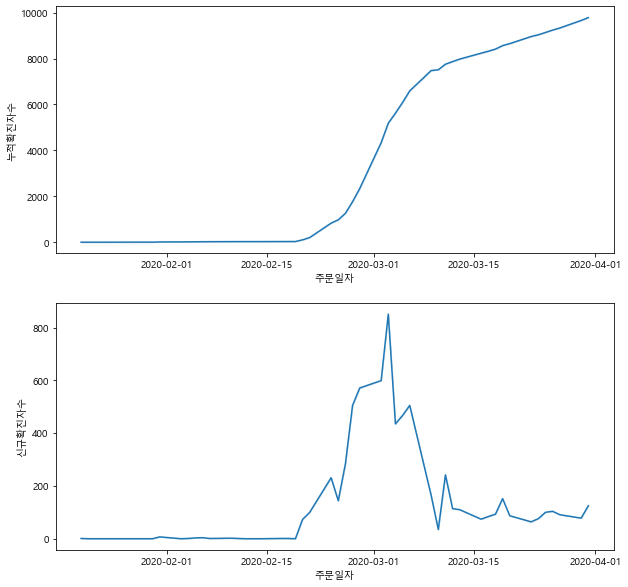

In [35]:
# COVID-19 확진자수 추이 시각화 
fig,((ax1), (ax2)) = plt.subplots(2, 1, figsize=(10, 10))

sns.lineplot(kis['주문일자'], kis['누적확진자수'], ax = ax1)
sns.lineplot(kis['주문일자'], kis['신규확진자수'], ax = ax2)

# COVID-19 상황의 업종 탐구 분석

## COVID-19 확진자 수와 업종별 당일종가 평균 추이를 비교 분석

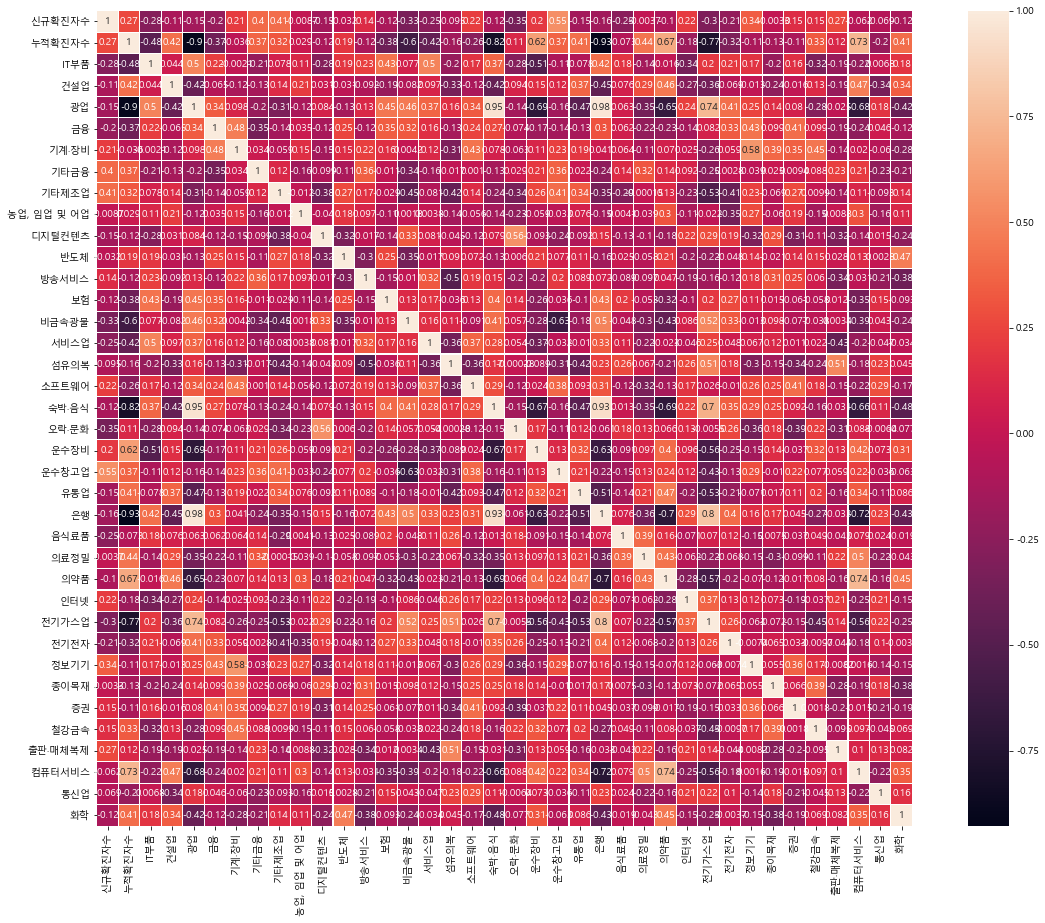

In [36]:
# 업종별 당일종가 평균 구하기
_sector_cp = kis.groupby(['주문일자', '업종명'])['당일종가'].mean().to_frame().reset_index()
_sector_cp = pd.pivot_table(_sector_cp, index = '주문일자', columns = '업종명', values = '당일종가').reset_index()
_sector_cp = _sector_cp.interpolate(method = 'linear', limit_direction = 'both')  # 결측치 보간 (해당일에 고객들이 거래를 하지 않았던 비선호 업종들이기 때문에 결측치는 단순 선형 보간으로 처리)

# COVID-19 확진자수 추이와 업종별 당일종가 평균의 상관관계 heatmap으로 시각화 
plt.figure(figsize=(20, 15))
sns.heatmap(pd.merge(covid, _sector_cp, on = '주문일자', how = 'left').corr(), linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True)

신규확진자수, 누적확진자수 추이에 대하여 당일종가가 각각 상관계수가 0.5 이상인 업종들을 COVID-19 상관적 업종으로 분류한다. 여기서는 신규확진자수와 상관성이 있는 산업은 ‘운수창고업’이었으며, 누적확진자수와 상관성이 있는 산업은 ‘컴퓨터서비스’, ‘의약품’, ‘운수장비’로 도출하였다.

In [37]:
# COVID-19 확진자 수와 업종별 수치 비교 시각화 함수 
def covid_sector(watch_name:str, confirm_name:str, sector_name:str):
    # COVID-19 확진자 수와 업종별 당일종가 평균 비교 
    if watch_name == '당일종가' :  
        ax = covid.plot('주문일자', confirm_name, color = 'blue', legend = False, figsize=(15, 8))
        ax2 = ax.twinx()
        _sector_cp.plot('주문일자', sector_name, ax = ax2, color = 'red', legend = False)

        ax.figure.legend()
        ax.set_title(f'COVID-19 {confirm_name} 추이 및 {sector_name} 당일종가 평균 추이 비교',  fontsize = 15)
        plt.show()

    # COVID-19 확진자 수와 업종별 거래량 평균 비교  
    elif watch_name == '거래수량':
        ax = covid.plot('주문일자', confirm_name, color = 'blue', legend = False, figsize=(15, 8))
        ax2 = ax.twinx()
        _sector_vol.plot('주문일자', sector_name, ax = ax2, color = 'red', legend = False)

        ax.figure.legend()
        ax.set_title(f'COVID-19 {confirm_name} 추이 및 {sector_name} 거래량 평균 추이 비교',  fontsize = 15)
        plt.show()    

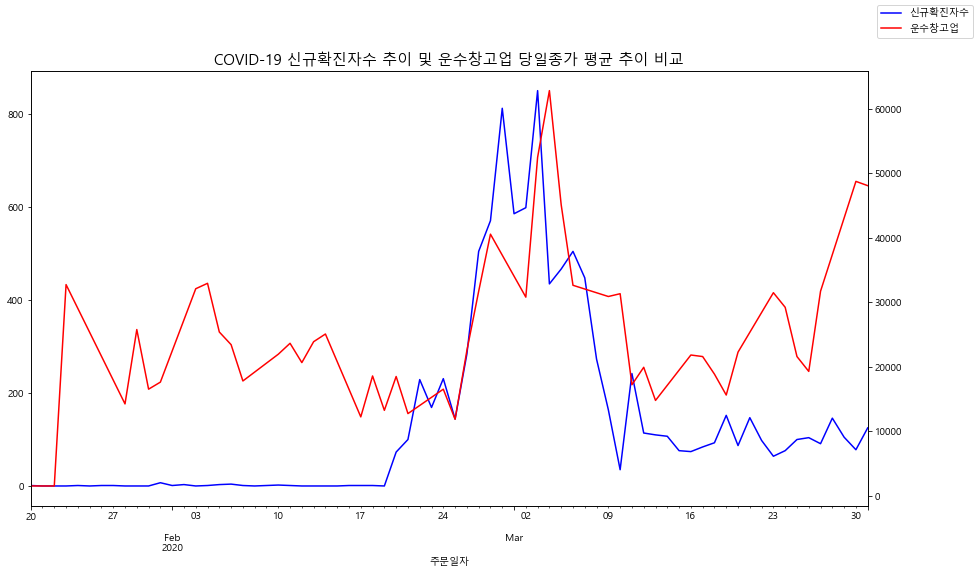

In [38]:
# COVID-19 신규확진자 수와 운수창고업 업종 당일종가 평균 비교  
covid_sector('당일종가', '신규확진자수', '운수창고업')

운수창고업 당일종가 평균은 COVID-19 신규확진자수 추이와의 상관계수가 0.55였으며 line plot 상으로도 상당한 유사성을 띄고 있다. 

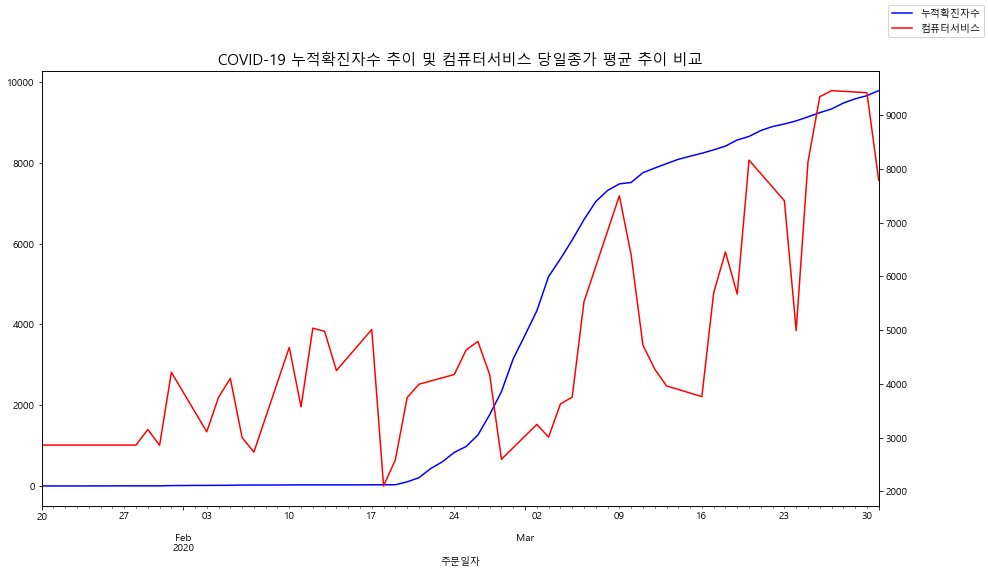

In [39]:
# COVID-19 누적확진자 수와 컴퓨터서비스 업종 당일종가 평균 비교  
covid_sector('당일종가', '누적확진자수', '컴퓨터서비스')

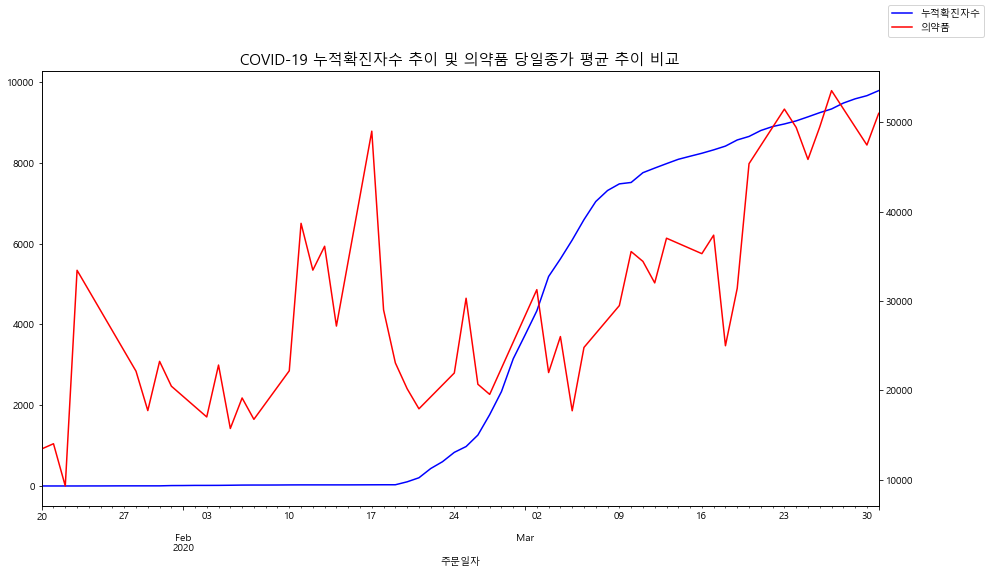

In [40]:
# COVID-19 누적확진자 수와 의약품 업종 당일종가 평균 비교  
covid_sector('당일종가', '누적확진자수', '의약품')

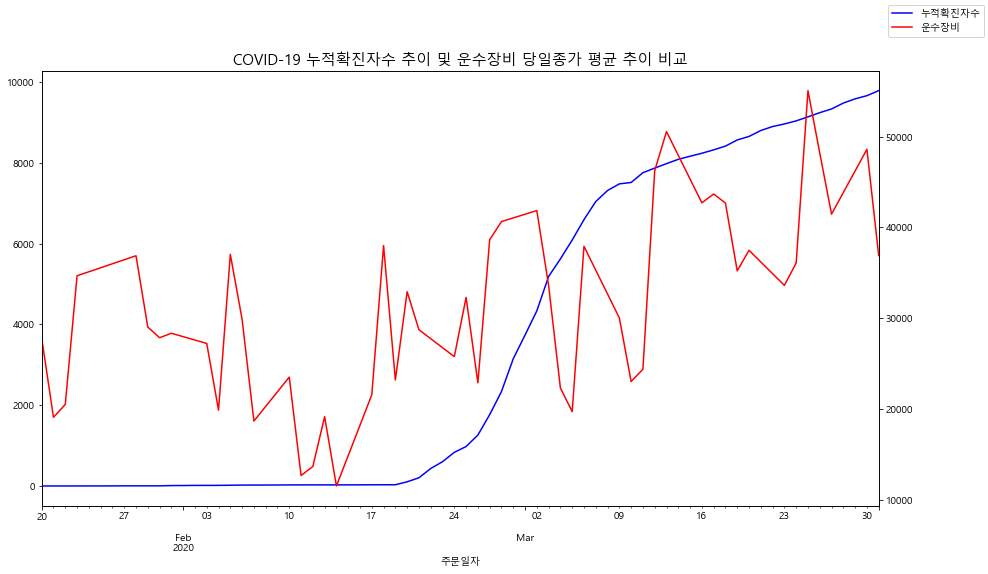

In [41]:
# COVID-19 누적확진자 수와 운수장비 업종 당일종가 평균 비교  
covid_sector('당일종가', '누적확진자수', '운수장비')

컴퓨터서비스, 의약품, 운수장비 업종은 COVID-19 누적확진자수 추이와 상관계수가 각각 0.73, 0.67, 0.62였으며 COVID-19 누적확진자수 증가와 함께 우상향하고 있다. 물론 이러한 업종의 상승세는 단순히 COVID-19만이 직접적인 영향 요소는 아니기에 다양한 요인을 고려해야 한다. 그러나 데이터를 분석하는 기간인 20.01.20-20.03.31 사이에는 COVID-19 국내 확진자 첫 발발 직후 사회경제적으로 가장 큰 변동이 있었던 시기였기 때문에, 주식시장에서도 COVID-19로 인한 영향력이 가장 강했던 점을 고려하여 이와 같은 COVID-19 확진자수 추이와 관련 업종과의 추이적 상관성을 해석할 수 있다.

## COVID-19 확진자 수와 업종별 거래량 평균 추이를 비교 분석

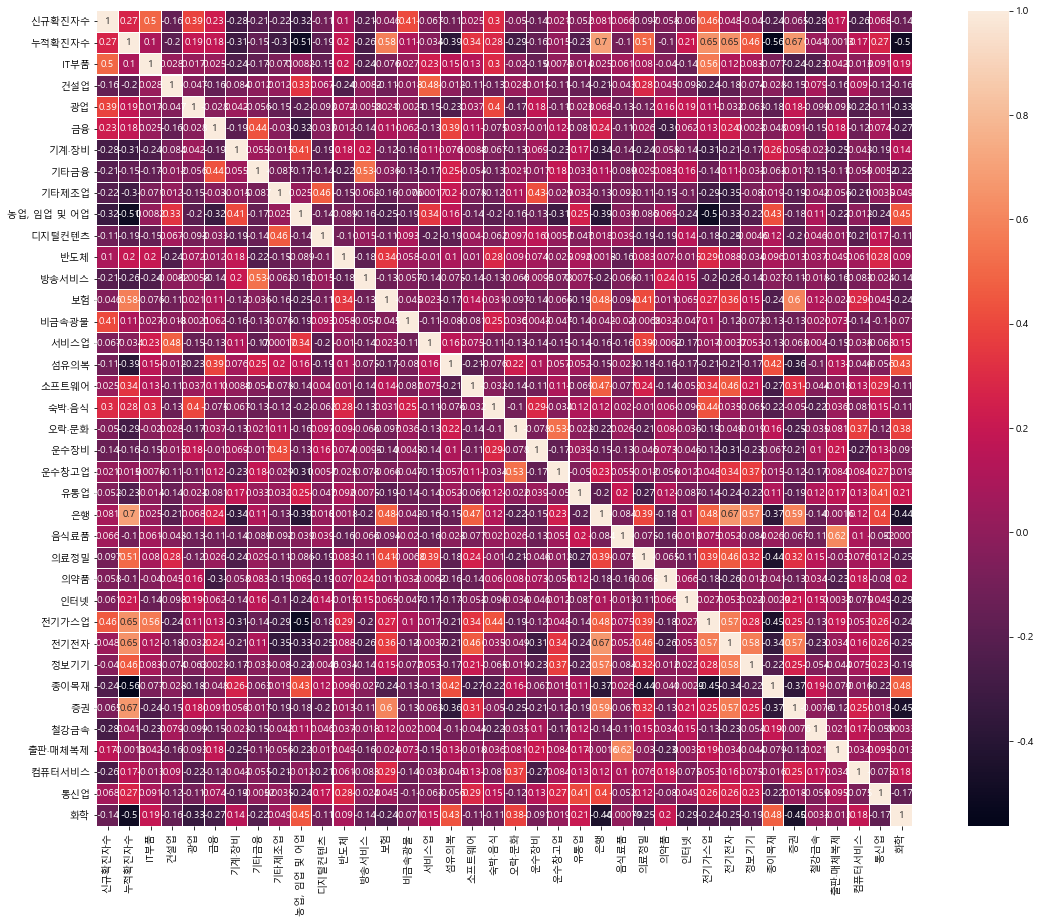

In [42]:
# 업종별 일별 거래량 평균 구하기
_sector_vol = kis.groupby(['주문일자', '업종명'])['거래수량'].mean().to_frame().reset_index()
_sector_vol = pd.pivot_table(_sector_vol, index = '주문일자', columns = '업종명', values = '거래수량').reset_index()
_sector_vol = _sector_vol.interpolate(method = 'linear', limit_direction = 'both') # 결측치 보간 (해당일에 고객들이 거래를 하지 않았던 비선호 업종들이기 때문에 결측치는 단순 선형 보간으로 처리)

# COVID-19 확진자수 추이와 업종별 거래량의 상관관계 heatmap으로 시각화 
plt.figure(figsize=(20, 15))
sns.heatmap(pd.merge(covid, _sector_vol, on = '주문일자', how = 'left').corr(), linewidths = 0.1, vmax = 1.0, square = True, linecolor = 'white', annot = True)

신규확진자수, 누적확진자수 추이에 대하여 각각 거래량의 상관계수가 0.5 이상인 업종들을 COVID-19 상관적 업종으로 분류한다. 여기서는 신규확진자수와 상관성이 있는 산업은 ‘IT부품’이었으며, 누적확진자수와 상관성이 있는 산업은 ‘은행’, ‘보험’, ‘증권’, ‘전기가스업’, ‘전기전자’, ‘의료정밀’로 도출하였다.

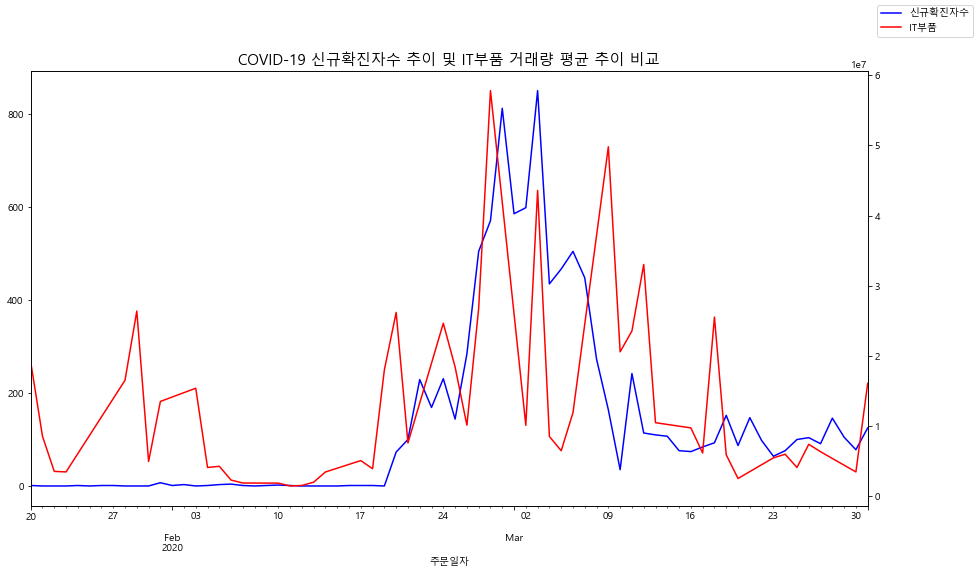

In [43]:
# COVID-19 신규확진자 수와 IT부품 업종 거래량 평균 비교  
covid_sector('거래수량', '신규확진자수', 'IT부품')

COVID-19 신규확진자수 추이와 IT부품 거래량은 그래프가 매우 유사한 추이를 보이고 있으며 상관계수는 0.5에 해당한다. 급격한 COVID-19 확진자수 증가로 인하여 비대면 업무나 수업 등이 확산되면서 IT부품에 대한 관심도가 증가한 것으로 해석된다.

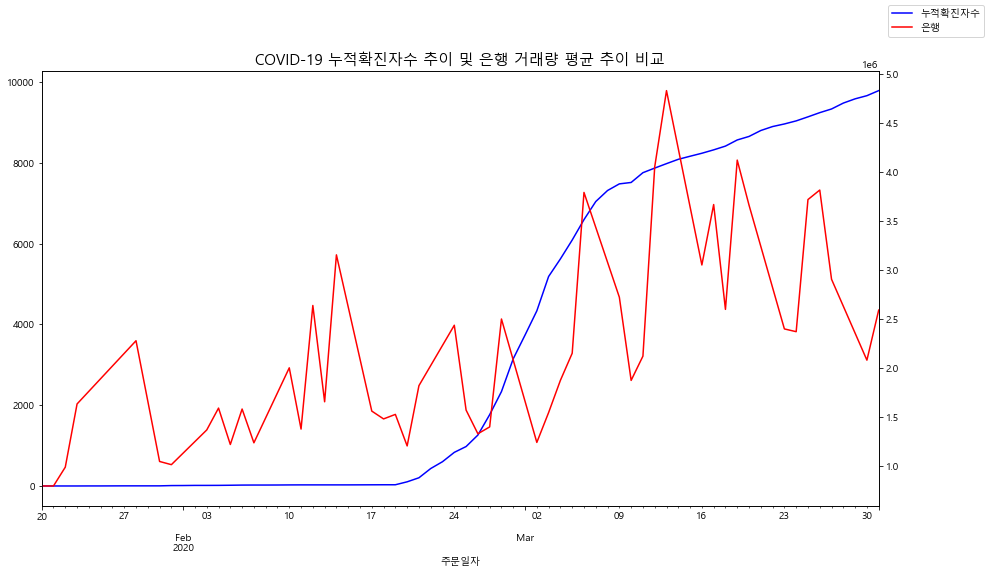

In [44]:
# COVID-19 누적확진자 수와 은행 업종 거래량 평균 비교  
covid_sector('거래수량', '누적확진자수', '은행')

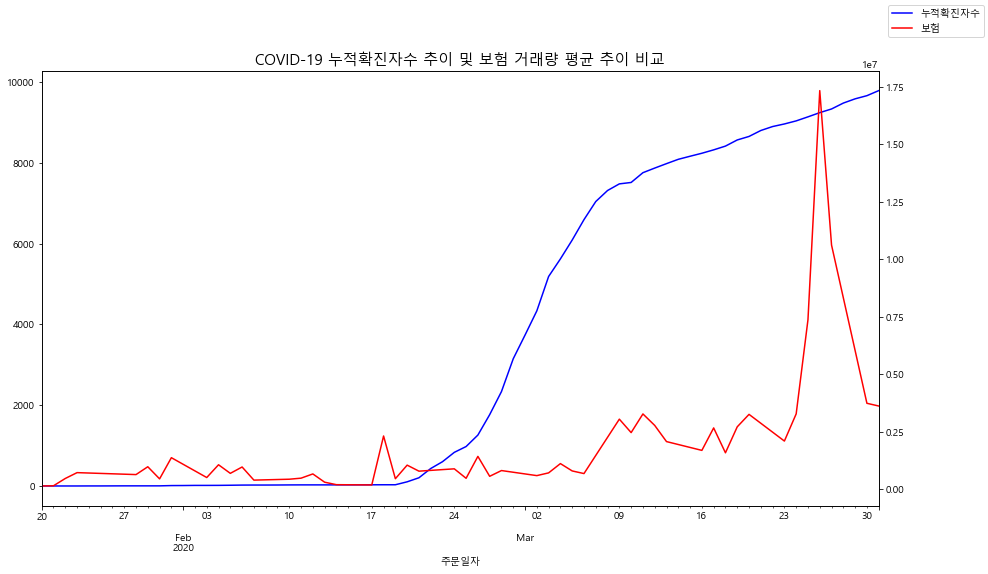

In [45]:
# COVID-19 누적확진자 수와 보험 업종 거래량 평균 비교  
covid_sector('거래수량', '누적확진자수', '보험')

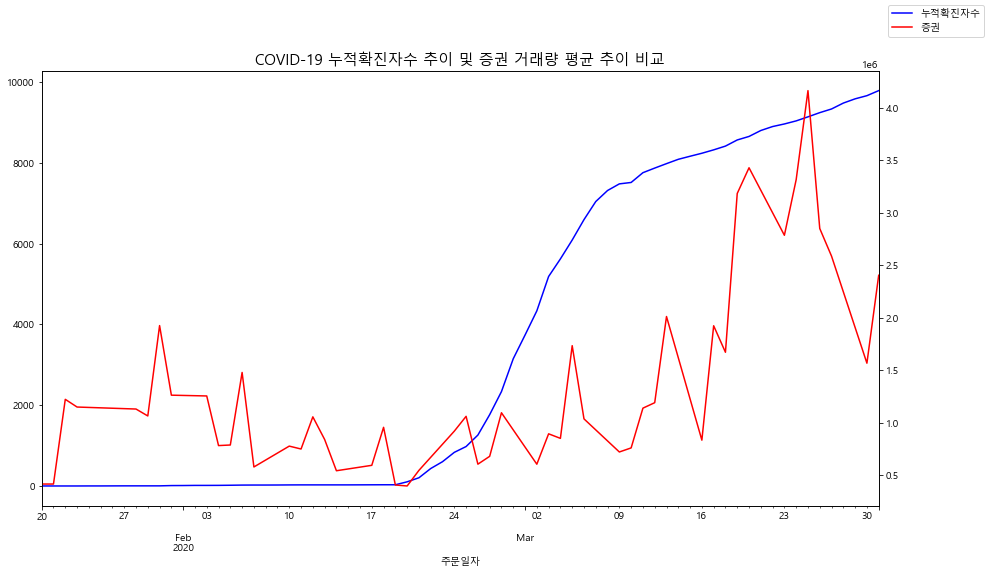

In [46]:
# COVID-19 누적확진자 수와 증권 업종 거래량 평균 비교  
covid_sector('거래수량', '누적확진자수', '증권')

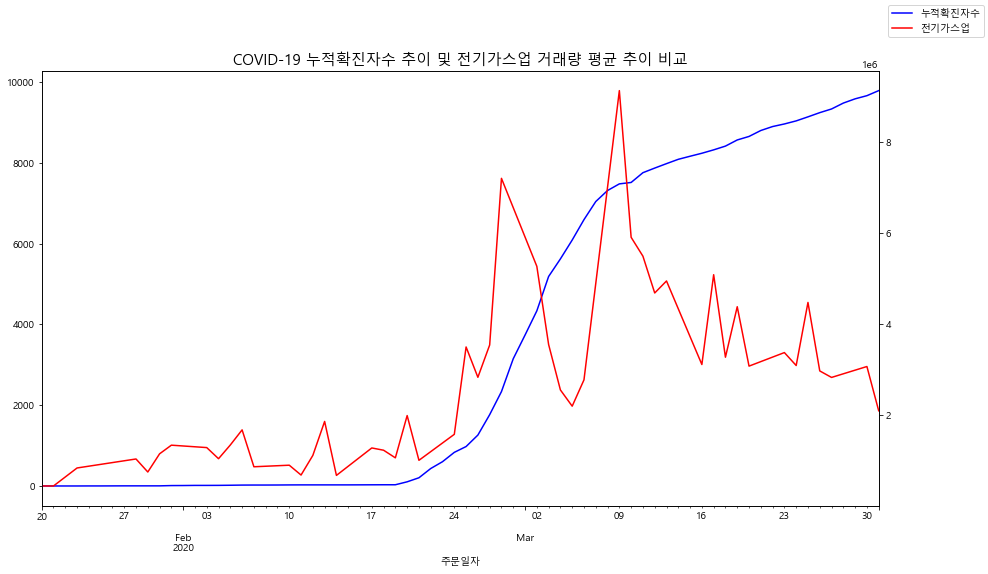

In [47]:
# COVID-19 누적확진자 수와 전기가스업 업종 거래량 평균 비교  
covid_sector('거래수량', '누적확진자수', '전기가스업')

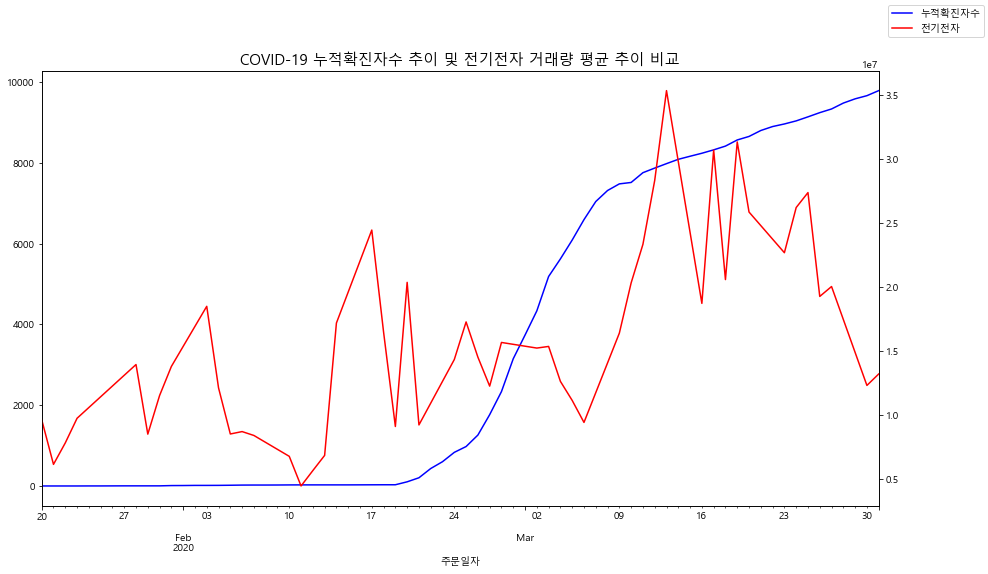

In [48]:
# COVID-19 누적확진자 수와 전기전자 업종 거래량 평균 비교  
covid_sector('거래수량', '누적확진자수', '전기전자')

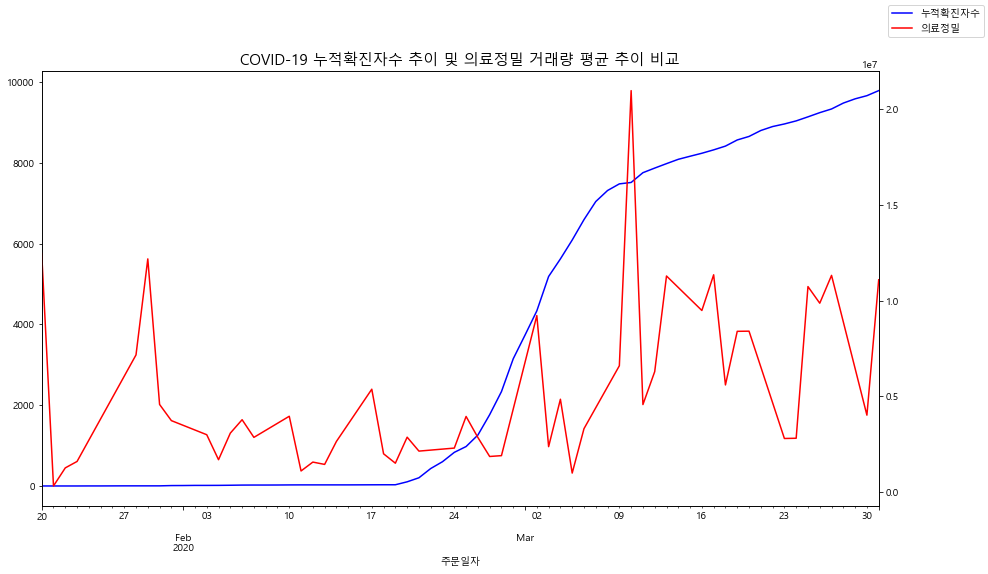

In [49]:
# COVID-19 누적확진자 수와 의료정밀 업종 거래량 평균 비교  
covid_sector('거래수량', '누적확진자수', '의료정밀')

은행, 증권, 전기가스업, 전기전자, 보험, 의료정밀 업종의 거래량은 COVID-19 누적확진자수 추이와 상관계수가 각각 0.7, 0.67, 0.65, 0.65, 0.58, 0.51이었으며 COVID-19 누적확진자수 증가와 함께 우상향하고 있다. 이렇게 거래량이 증가한 배경으로는, 전기전자나 의료정밀 업종의 경우 수요가 상승한 결과였으나 은행, 증권, 보험, 전기가스업 등은 코로나 상황으로 인하여 안정성이 떨어지며 매도세가 강했던 결과라고 해석된다.

# 신규고객별 매매패턴, 특성 도출
K Means Clustering을 진행하기 위하여 개별 신규고객의 데이터를 별도로 추가하였다. 신규고객별 동학개미운동 기간동안의 주문횟수와 주문간격, 매매종목수, 총거래액, 매수액 비중, 매도액 비중, 투자 업종 비중, 투자 기업 종류별 비중 등의 매매패턴과 특성을 도출하고 이러한 특징을 바탕으로 Clustering을 진행한다.

## 신규고객별 주문횟수와 주문간격, 매매종목수

In [50]:
# 고객별 데이터프레임 생성 
investor = kis.groupby('고객구분코드')['고객성별구분코드', '동일나이군구분코드'].mean().reset_index()

# 고객별 주문횟수 
_count =  kis.groupby('고객구분코드')['주문일자'].count().to_frame('주문횟수').reset_index()
investor = pd.merge(investor, _count, how = 'left', on = '고객구분코드')

# 고객별 주문간격 (일자 기준)
_gap = kis.groupby('고객구분코드')['주문일자'].apply(lambda x : dt.datetime.strptime('2020-03-31', '%Y-%m-%d') - x.min()).apply(lambda x: x.days).to_frame('전체주문간격')
investor = pd.merge(investor, _gap, how = 'left', on = '고객구분코드')
investor['주문간격'] = investor['전체주문간격'] / investor['주문횟수']
investor = investor.drop(columns = '전체주문간격')

# 고객별 매매종목수 구하기 
_stock_n = kis.groupby('고객구분코드')['상품명'].nunique().to_frame('매매종목수')
investor = pd.merge(investor, _stock_n, on = '고객구분코드', how = 'left')

## 신규고객별 총거래액 및 매수액 비중, 매도액 비중

In [51]:
# 고객별 총 거래액
_amount = kis.groupby('고객구분코드')['총체결금액'].sum().to_frame('총거래액').reset_index()
investor = pd.merge(investor, _amount, how = 'left', on = '고객구분코드')

# 총 거래액 중 매수액 비중 
_amount = kis.loc[kis['매도매수구분코드'] == 2].groupby(['고객구분코드'])['총체결금액'].sum().to_frame('매수액').reset_index()
investor = pd.merge(investor, _amount, how = 'left', on = '고객구분코드')
investor['매수액비중'] = investor['매수액'] / investor['총거래액']

# 총 거래액 중 매도액 비중 
_amount = kis.loc[kis['매도매수구분코드'] == 1].groupby(['고객구분코드'])['총체결금액'].sum().to_frame('매도액').reset_index()
investor = pd.merge(investor, _amount, how = 'left', on = '고객구분코드')
investor['매도액비중'] = investor['매도액'] / investor['총거래액']
investor = investor.fillna(0)
investor = investor.drop(columns = ['매수액', '매도액'])

## 신규고객별 투자 업종 비중, 투자 기업 종류별 비중

In [52]:
# 고객별 매매금액 중 업종별 거래액 비중 
_sector = kis.groupby(['고객구분코드', '업종명'])['총체결금액'].sum().to_frame('업종별거래액').reset_index()
_sector = pd.pivot_table(_sector, index = '고객구분코드', columns = '업종명', values = '업종별거래액').reset_index()
_sector = _sector.fillna(0)
investor = pd.merge(investor, _sector, how = 'left', on = '고객구분코드')
for i in list(kis['업종명'].unique()):
    investor[i] = investor[i] / investor['총거래액']

# 고객별 매매금액 중 기업종류별 거래액 비중 
_corp = kis.groupby(['고객구분코드', '기업분류'])['총체결금액'].sum().to_frame('기업분류별거래액').reset_index()
_corp = pd.pivot_table(_corp, index = '고객구분코드', columns = '기업분류', values = '기업분류별거래액').reset_index()
_corp = _corp.fillna(0)
investor = pd.merge(investor, _corp, how = 'left', on = '고객구분코드')
for i in list(kis['기업분류'].unique()):
    investor[i] = investor[i] / investor['총거래액']

In [53]:
investor

,고객구분코드,고객성별구분코드,동일나이군구분코드,주문횟수,주문간격,매매종목수,총거래액,매수액비중,매도액비중,IT부품,건설업,광업,금융,기계·장비,기타금융,기타제조업,"농업, 임업 및 어업",디지털컨텐츠,반도체,방송서비스,보험,비금속광물,서비스업,섬유의복,소프트웨어,숙박·음식,오락·문화,운수장비,운수창고업,유통업,은행,음식료품,의료정밀,의약품,인터넷,전기가스업,전기전자,정보기기,종이목재,증권,철강금속,출판·매체복제,컴퓨터서비스,통신업,화학,기술성장기업,대형기업,벤처기업,별도관리기업,우량기업,중견기업
0,A0001,1,30,758,0.092348,149,137891782,0.507000,0.493000,0.036988,0.001059,0.005838,0.039321,0.023320,0.006107,0.001748,0.0,0.033841,0.043327,0.000848,0.001530,0.015068,0.129547,0.057981,0.010190,0.004819,0.028133,0.090147,0.044866,0.029182,0.000000,0.015290,0.016673,0.171361,0.0,0.000000,0.035078,0.013924,0.015645,0.000000,0.019219,0.006841,0.00000,0.004286,0.097825,0.100794,0.243467,0.121456,0.027684,0.246501,0.260099
1,A00010,1,20,15,4.533333,10,927070,0.782411,0.217589,0.085964,0.000000,0.000000,0.000000,0.040677,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041744,0.000000,0.000000,0.000000,0.064272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.059111,0.000000,0.000000,0.000000,0.247522,0.000000,0.00357,0.371277,0.085862,0.000000,0.280324,0.085964,0.000000,0.000000,0.633712
2,A000100,2,40,14,3.571429,10,14770590,0.819261,0.180739,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.169255,0.000000,0.000000,0.000000,0.016992,0.000000,0.000000,0.017685,0.067702,0.034731,0.000000,0.510257,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.183378,0.00000,0.000000,0.000000,0.000000,0.629069,0.000000,0.000000,0.166953,0.203978
3,A0001000,1,30,11,1.181818,6,1632487,0.749392,0.250608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.277396,0.000000,0.465609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158402,0.0,0.000000,0.000000,0.000000,0.089165,0.009429,0.000000,0.000000,0.00000,0.000000,0.000000,0.158402,0.375989,0.465609,0.000000,0.000000,0.000000
4,A00010000,1,20,27,1.185185,12,27507090,0.652059,0.347941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.032799,0.000000,0.000000,0.000000,0.025269,0.000000,0.000000,0.000000,0.000000,0.039084,0.135610,0.000000,0.000000,0.000000,0.249734,0.119353,0.0,0.000000,0.398151,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.249734,0.576781,0.058092,0.000000,0.057326,0.058068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24984,A0009995,1,30,15,1.933333,6,31284680,0.617306,0.382694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.080870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.470539,0.000000,0.000000,0.000000,0.000000,0.000000,0.047083,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.401508,0.000000,0.00000,0.000000,0.000000,0.000000,0.918253,0.000000,0.000000,0.081747,0.000000
24985,A0009996,1,40,20,1.450000,12,10256165,0.455347,0.544653,0.000000,0.000000,0.000000,0.104706,0.131593,0.000000,0.000000,0.0,0.000000,0.071498,0.000000,0.000000,0.000000,0.048276,0.000000,0.078479,0.000000,0.000000,0.155676,0.000000,0.000000,0.000000,0.000000,0.000000,0.165350,0.0,0.000000,0.244421,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.034170,0.109325,0.353681,0.000000,0.300165,0.202659
24986,A0009997,1,20,6,4.833333,2,1489450,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.027359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.972641,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.972641,0.027359,0.000000,0.000000,0.000000
24987,A0009998,1,50,59,0.491525,10,257821563,0.973275,0.026725,0.000000,0.000000,0.000000,0.032002,0.020953,0

# 신규고객의 매매패턴 및 특성에 따른 군집화

## K Means Clustering

In [54]:
# Clustering을 위한 고객별 특성 값을 Min Max Scaling
_df = investor[['주문횟수', '주문간격', '매매종목수', '총거래액']]
scaler = MinMaxScaler()
_df = pd.DataFrame(scaler.fit_transform(_df), columns = _df.columns)
kmeans_df = pd.concat([investor.iloc[:, 7:], _df], axis = 1)

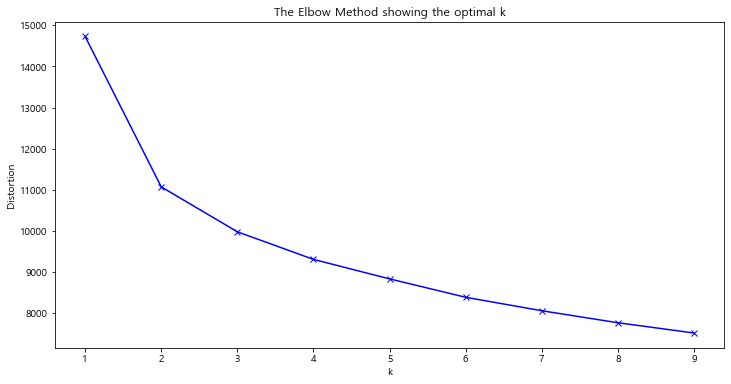

In [57]:
# Kmeans Clustering 시 Elbow Method를 적용하여 몇개의 군집으로 나눌지 파악 
# 코드 참고 : https://predictivehacks.com/k-means-elbow-method-code-for-python/
distortions = []

K = range(1, 10)
for k in K:
    kmean = KMeans(n_clusters = k, random_state = 26)
    kmean.fit(kmeans_df)
    distortions.append(kmean.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

K Means Clustering 시 Elbow Method를 적용하여 몇개의 군집으로 나눌지 파악하였다. Elbow Method 결과에 따라 3개 군집으로 clustering하는 것이 가장 적합하다고 판단된다.

In [58]:
# 비슷한 특성을 가진 고객들끼리 3개 군집으로 KMeans Clustering 
km = KMeans(n_clusters = 3, random_state = 26)
km.fit(kmeans_df)
cluster = km.predict(kmeans_df)

investor['cluster'] = cluster

## 군집화 결과 해석
군집화 결과 0, 1, 2번 군집으로 고객들의 매매패턴과 특성을 분류할 수 있었다.

In [59]:
# cluster별 boxplot 시각화 함수 
def cluster_boxplot(df:pd.DataFrame, col_list:list):
    fig = plt.figure(figsize=(20, 4*len(col_list)))
    
    for i, c in enumerate(col_list):
        ax = fig.add_subplot(len(col_list), 4, i+1)
        ax.set(title = c)
        sns.boxplot(df['cluster'], df[c], showfliers = False)

    plt.tight_layout()
    plt.show()

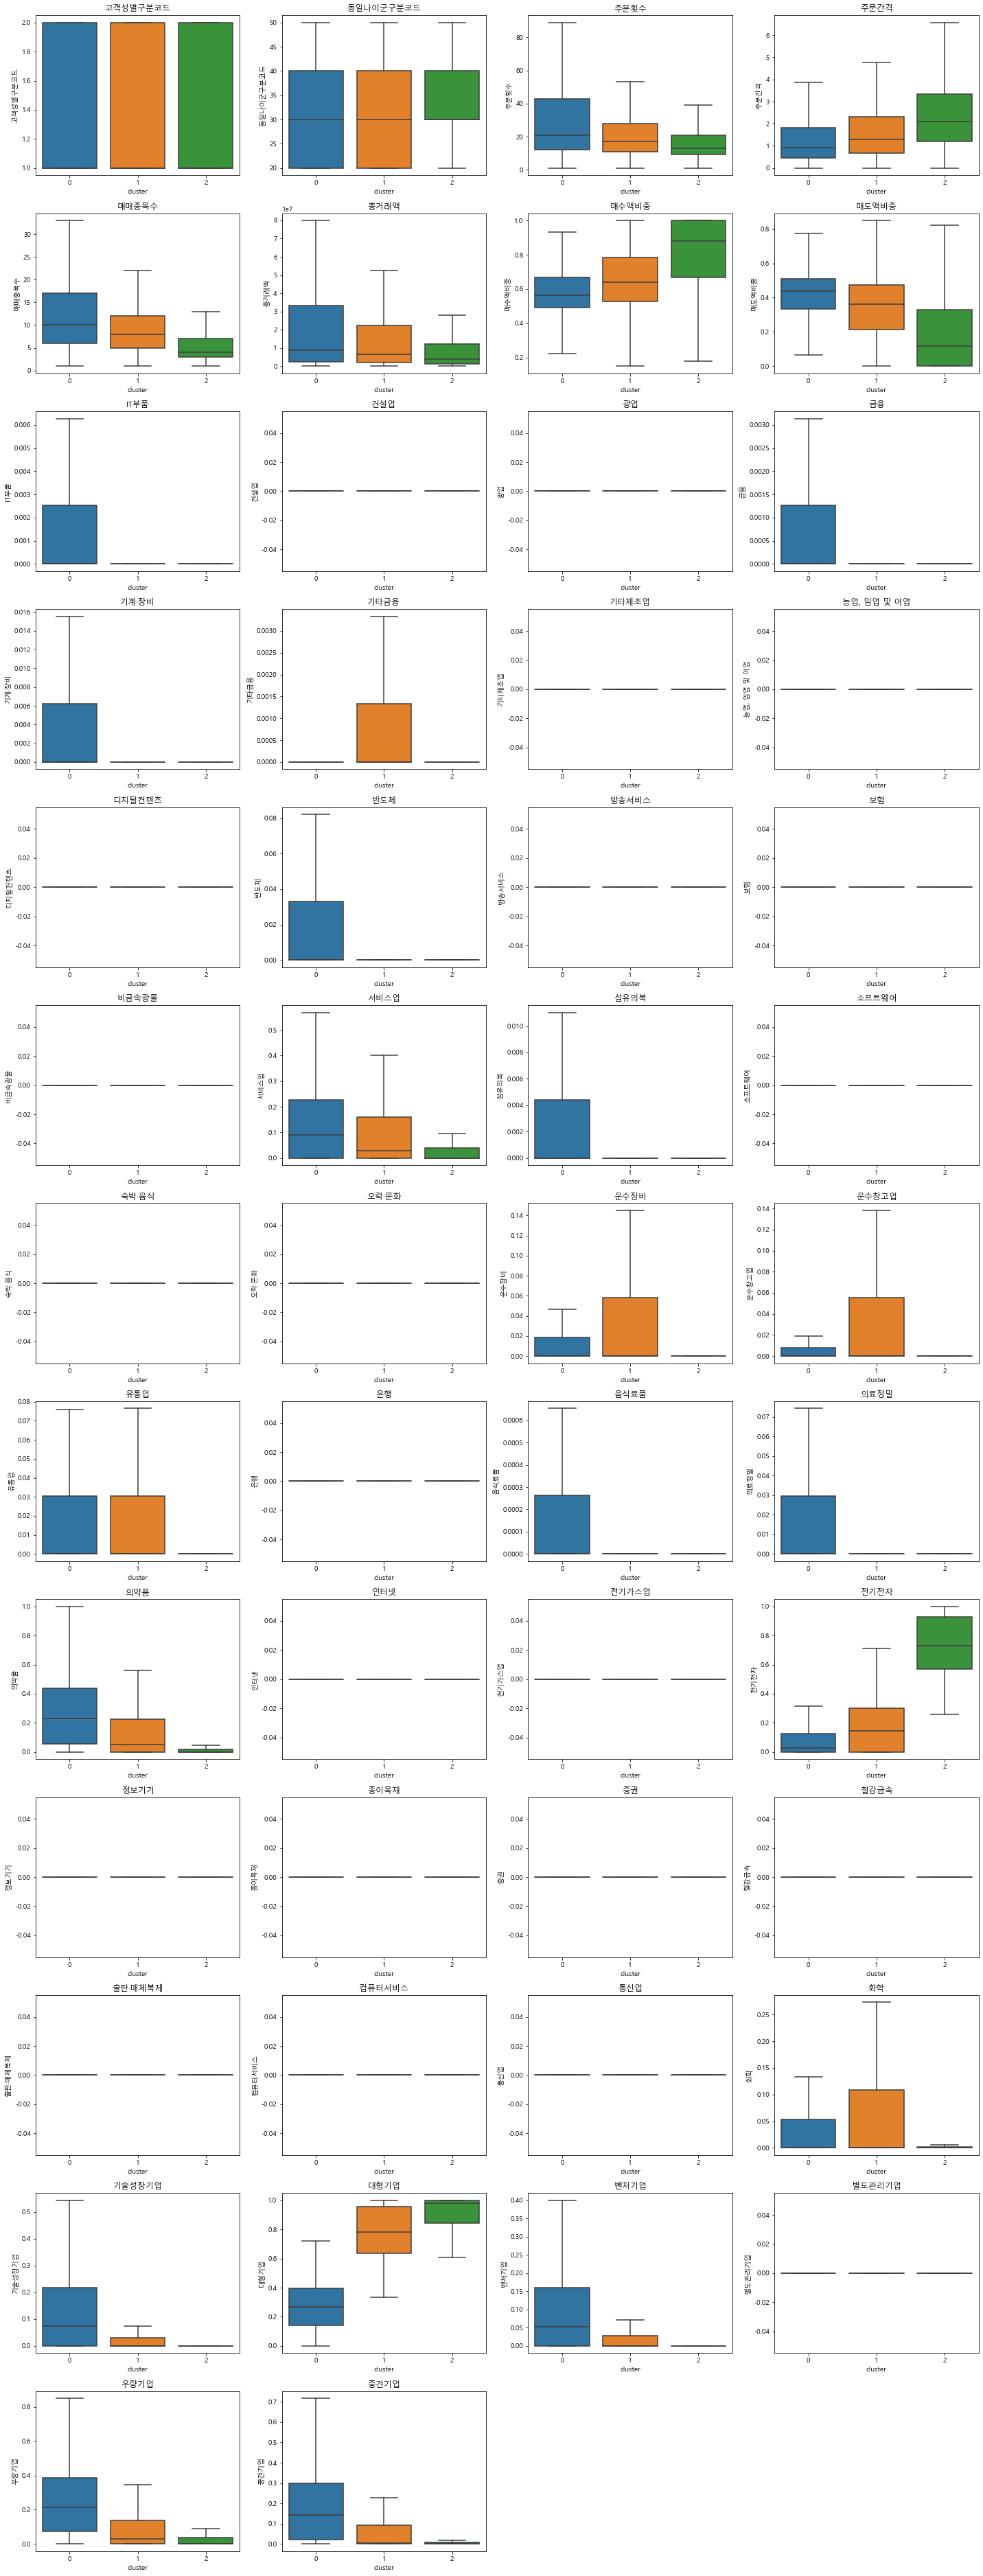

In [60]:
# cluster별 각종 특성 및 매매패턴 시각화 
col_list = list(investor.columns)
col_list.remove('고객구분코드')
col_list.remove('cluster')
cluster_boxplot(investor, col_list)

군집화 결과 0, 1, 2번 군집으로 고객들의 매매패턴과 특성을 분류할 수 있었다.
1. 성별 : 0, 1, 2번 군집 모두 성별은 골고루 분포하였다.
2. 나이 : 0, 1번 군집은 연령이 고루 분포하였으나 3번 군집의 경우 30대, 40대가 많았다.
3. 주문 횟수 : 0번 군집의 주문횟수가 가장 많았고 그 다음으로 1, 2번 군집 순이었다.
4. 주문 간격 : 평균적인 주문간격일은 주문횟수가 많았던 0번 군집이 가장 짧고, 주문횟수가 적었던 2번 군집이 가장 간격이 컸다.
5. 매매종목수 : 0번 군집의 매매종목수가 가장 많았으며 그 다음으로 1, 2 군집 순이었다.
6. 총거래액 : 주문횟수가 많고 거래회전율이 높은 0번 군집의 총거래액이 가장 컸다.  
7. 매수액비중 : 총거래액 중 매수액 비중이 가장 높았던 것은 2번 군집이었다. 특히 동학개미운동 기간동안은 매도를 하지 않은 고객들이 2번 군집에 포진해있었다. 그리고 1번 군집은 매수의 비중이 좀 더 큰 편이었다.
8. 매도액비중 : 총거래액 중 매도액 비중이 가장 높은 것은 1번 군집이었다. 매수액비중과 반대 경향이므로 설명은 생략하도록 한다. 
9. 업종별 거래액 비중 <br>
① 0번 군집 : 0번 군집은 잦은 매도, 매수를 하는 군집이다보니 대부분 업종에서 다른 군집에 비하여 거래액 비중이 높았다. 0번 군집의 경우 IT부품, 금융, 기계·장비, 반도체, 서비스업, 섬유의복, 음식료품, 의료정밀, 의약품에서의 거래액 비중이 1, 2번 군집에 비하여 두드러지게 높았다. 유통업은 0번과 1번 군집의 거래액 비중이 비슷하였다.<br>
② 1번 군집 : 1번 군집은 기타금융, 운수장비, 운수창고업, 화학 업종에서의 거래액 비중이 다른 군집에 비하여 눈에 띄게 높았다.<br> 
③ 2번 군집 : 2번 군집은 서비스업과 유통업, 의약품에 대한 매매가 이루어졌다. 2번 군집의 경우 다른 군집에 비하여 전기전자 업종에 대한 선호도가 두드러졌다. 2번 군집은 매도를 잘 하지 않기 때문에 장기투자의 주된 업종으로 꼽히는 전기전자 업종에 대한 관심이 큰 것으로 보인다.<br>
10. 기업종류별 거래액 비중 <br>
① 0번 군집 : 0번 군집은 기술성장기업, 벤처기업, 중견기업, 우량기업에 대하여 타 군집에 비해 거래액 비중이 높았다. <br>
② 1번 군집 : 1번 군집의 경우에는 대형기업 위주로 매매가 이루어졌고 우량기업, 중견기업에 대해서도 매매 비중이 다소 있었다.<br>
③ 2번 군집 : 2번 군집은 압도적으로 대형기업 비중이 높았으며 우량기업에 대한 비중도 다소 존재하였으나 기술성장기업이나 중견기업, 벤처기업에 대한 비중은 미미했다. <br><br><br>


이러한 매매패턴과 특성에 따라 0번 군집을 스피드형(단기투자형), 1번 군집을 관심형(단기투자는 아니지만 다양한 관심을 갖고 투자하는 가치투자 유형), 2번 군집을 안정형(장기투자형)으로 분류해볼 것이다.<br><br>

**① 안정형 : 보통 대형, 우량주에 투자를 하거나 안정적으로 장기투자를 하는 유형. <br>
② 관심형 : 단기매도가 많진 않지만 시장 상황에 다양한 관심을 갖고 안정형보다 여러가지 종목에 투자하는 유형. 관심형이 집중하는 산업에서 향후 유망산업을 도출해볼 수 있을 것이다.<br>
③ 스피드형 :  거래회전율이 높고 종목 교체율이 높은 유형. 단기투자 유형이라고 볼 수 있다.** <br><br>


In [61]:
# 0, 1, 2번 군집을 활동가형, 관심형, 안정형으로 명칭 변경
investor['cluster'] = investor['cluster'].replace({0 : '스피드형', 1 : '관심형', 2 : '안정형'})

kis = pd.merge(kis, investor[['고객구분코드', 'cluster']], on = '고객구분코드', how = 'left')

# 고객 유형별 체결금액에 근거한 종목 비교 분석
고객 유형별 비교를 하기 전에 우선 동학개미운동 기간의 신규고객 거래와 시장 전체 거래를 비교하는 작업을 우선 진행할 것이다. 이를 통하여 신규고객 전체의 특성을 파악하고 그 후 유형별 비교를 통하여 그 특성을 구체화할 것이다.

## 신규고객의 체결금액과 시장 전체의 거래대금에 근거한 종목 비교 분석
신규고객의 거래 특징뿐만 아니라 준거집단의 거래 특징을 비교하면 더 유의미한 결과가 도출될 것이라는 판단 하에, 신규고객의 거래와 시장 전체 거래의 특징을 비교 시각화 한다. 각 기업별 시장 전체의 거래대금에 따른 특징을 준거로 하여, 신규고객이 주문체결한 기업의 총체결금액에 따른 특징을 비교하였다.

In [62]:
# 동학개미운동(20.01.20 ~ 20.03.31) 기간 기준 신규고객들이 거래한 종목별 체결수량, 체결금액 및 해당 종목의 시장 전체 거래수량, 거래대금 
all_trade = kis.groupby(['상품명', '업종명', '기업분류']).agg({'총체결수량' : 'sum', '총체결금액' : 'sum'}).reset_index()
_market_trade = kis.groupby(['주문일자', '상품명']).agg({'거래수량' : 'mean', '거래대금' : 'mean'}).reset_index()
_market_trade = _market_trade.groupby('상품명').agg({'거래수량' : 'sum', '거래대금' : 'sum'}).reset_index()
all_trade = pd.merge(all_trade, _market_trade, how = 'left', on = '상품명')

In [170]:
# 신규고객의 거래와 시장 전체 거래를 비교하기 위한 pie chart 시각화 함수 
def compare_all_pie(df:pd.DataFrame, col_label:str, col_val1:str, col_val2:str, title:str):
    fig = make_subplots(rows = 1, cols = 2, 
                        specs= [[{'type':'domain'}, {'type':'domain'}]],
                        subplot_titles = ('신규고객 거래', '시장 전체 거래'))
    
    fig.add_trace(go.Pie(labels = df[col_label], values = df[col_val1]), row = 1, col = 1)
    fig.add_trace(go.Pie(labels = df[col_label], values = df[col_val2]), row = 1, col = 2)
    
    fig.update_traces(textposition = 'inside', textinfo = 'percent+label')
    fig.update_layout(height = 500, width = 1200, title_text = title, uniformtext = dict(minsize = 10, mode = 'hide'))
    
    return fig

### 신규고객 거래 및 시장 전체 거래 상위 20개 종목 비교 분석 (체결금액과 거래대금 기준)

In [4]:
htmlfile_path = 'https://gadi-study.github.io/FinDataContest2021/htmlfile/'

In [14]:
IFrame(src= htmlfile_path + 'graph1', height = '525', width = '100%')

In [15]:
IFrame(src= htmlfile_path + 'graph2', height = '525', width = '100%')

동학개미운동(20.01.20 ~ 20.03.31) 기간동안 신규고객의 거래대금 상위 20개 종목과 시장 전체 거래대금 상위 20개 종목을 비교하였을 때 다음과 같은 특징이 있다.<br>

**신규고객 거래에서 '씨젠' 종목에 대한 관심** <br>
씨젠은 신규고객의 거래대금 2위 종목이며 신규고객의 전체 거래대금 비중의 6.36%를 차지하였다. 시장 전체에서도 씨젠은 거래대금 3위 종목으로 상위권이긴 하지만, 시장 전체 거래대금 비중의 2.46%라는 수치와 비교해볼 때 신규고객에서 씨젠의 거래대금 비중은 유의미하게 큰 편이다. 따라서 씨젠은 신규고객이 더 관심을 갖는 종목이라고 판단할 수 있다.<br>
**1위 종목 '삼성전자보통주'** <br> 
삼성전자보통주는 신규고객뿐만 아니라 시장 전체에서 가장 큰 거래대금 비중을 차지하는 종목이다. 이를 통하여 삼성전자는 국내 투자 시장에서 대표적이고 안정적인 투자 종목임을 확인할 수 있었다. <br>
**신규고객 거래에서 '이원다이애그노믹스(EDGC)' 종목의 약진** <br>
이원다이애그노믹스(EDGC)는 시장 전체에서는 상위 20개 종목에 들지 못했으나, 신규고객의 거래대금 3위를 차지한 상위권 종목이다. EDGC의 경우에는 동학개미운동(20.01.20 ~ 20.03.31) 기간동안 종가 기준으로 5,090원에서 19,800원으로 상승하여 주가 등락률이 288.9%를 기록하였으며 신규고객의 거래대금 비중 2.3%를 차지하여 시장 전체에서 EDGC의 거래대금 비중인 0.611%와 비교해볼 때 활발한 거래가 이루어졌음을 확인할 수 있다.

### 신규고객 거래와 시장 전체 거래에서의 관심 업종 비교 분석 (체결금액과 거래대금 기준)

In [16]:
IFrame(src= htmlfile_path + 'graph3', height = '525', width = '100%')

동학개미운동(20.01.20 ~ 20.03.31) 기간동안 신규고객 거래 업종과 시장 전체 거래 업종을 비교하였을 때 다음과 같은 특징이 있다.<br>

**신규고객의 '의약품' 업종에 대한 관심** <br>시장 전체 거래와 비교하였을 때 신규고객은 의약품 업종에 가장 관심이 많다는 것을 유추할 수 있었다. 신규고객의 거래대금 중 23.4%가 의약품 업종에 해당할 정도로 가장 활발한 거래가 이루어졌다. 그에 반해 시장 전체 거래대금을 살펴보면 의약품 업종의 비중은 15.1%로 비교적 낮을 수치였고 전기전자 업종이 21.2%로 더 높았다.

**신규고객의 '운수창고업' 업종에 대한 관심** <br> 시장 전체 거래와 신규고객의 거래는 대체로 비슷한 양상을 띠고 있다. 대표적인 주식 시장 대형기업들이 포진한 전기전자 업종, 서비스업, 화학, 운수장비, 유통업, 반도체 업종은 신규고객과 시장 전체 거래에서 모두 거래대금 비중 상위 종목이었다. 여기서 눈여겨 볼 점은 시장 전체 거래에 비하여 신규고객은 운수창고업 업종에 대한 거래대금 비중이 높았다는 것이다. 시장 전체 거래에서는 상위 종목 10위권 밖에 있던 운수창고업 종목이 신규고객 거래에서는 3.81%의 거래대금 비중을 차지하며 상위 7번째 종목에 해당되었다. 운수창고업은 '언택트' 시대의 대표적인 종목임을 확인할 수 있으며 동학개미운동 기간동안 신규고객들은 이러한 시대의 흐름을 빠르게 읽고 해당 종목에 대한 거래 관심도가 높았음을 유추해볼 수 있다. 

### 신규고객 거래와 시장 전체 거래에서의 선호되는 기업 종류 비교 분석 (체결금액과 거래대금 기준)

In [17]:
IFrame(src= htmlfile_path + 'graph4', height = '525', width = '100%')

동학개미운동(20.01.20 ~ 20.03.31) 기간동안 신규고객(랜덤선택)의 거래 종목 기업분류와 시장 전체 거래 종목 기업분류를 비교하였을 때 다음과 같은 특징이 있다. <br>

**시장 전체 거래 대비 신규고객에서 상대적으로 낮은 대형기업 비중** <br> 거래대금 비중이 높은 기업 종류를 살펴봤을 때 신규고객과 시장 전체 거래 모두에서 대형기업(KOSPI 상장주), 우량기업, 중견기업 순으로 거래대금 비중이 크다. 그러나 신규고객에서 대형기업의 거래대금 비중은 46.9%로, 시장 전체 거래대금에서 대형기업이 차지한 비중인 55.1%에 비하여 상대적으로 낮은 수치를 보이고 있다. 신규고객에서는 기술성장기업과 벤처기업 등의 거래대금 비중이 시장 전체에 비하여 높은 편이었다.

## '안정형' 신규고객 관심 종목 및 업종 분석 (체결금액 기준)

In [181]:
# 동학개미운동(20.01.20 ~ 20.03.31) 기간 신규고객 유형별 pie chart를 그리기 위한 함수 
def plot_pie(df:pd.DataFrame, label_name:str, cluster_name:str, slice_limit = -1):
    _df = df.loc[df['cluster'] == cluster_name].groupby(['상품명', '업종명', '기업분류'])['총체결금액'].sum().to_frame().reset_index()
    
    if slice_limit != -1:
        temp = _df.sort_values('총체결금액', ascending = False).iloc[slice_limit:]
        new_data = {'상품명' : '기타', '업종명' : '기타', '기업분류' : '기타', 
                    '총체결금액' : temp['총체결금액'].sum()}
        _df = _df.drop(temp.index)
        _df = _df.append(new_data, ignore_index = True)
    
    fig = px.pie(_df, names = label_name, values = '총체결금액',
                 title = f'동학개미운동(20.01.20 ~ 20.03.31) 기간 {cluster_name} 신규고객 거래 {label_name} 비중 (체결금액 기준)')
    
    fig.update_traces(rotation = 90, pull = 0.05, textinfo = 'percent+label', textposition = 'inside')
    fig.update_layout(height = 700, width = 1000, uniformtext_minsize = 10, uniformtext_mode = 'hide')
    
    return fig

In [176]:
# 동학개미운동(20.01.20 ~ 20.03.31) 기간 신규고객 유형별 거래 종목, 업종, 기업분류를 treemap으로 시각화하는 함수  
def plot_treemap(df:pd.DataFrame, cluster_name:'str'):
    _df = df.loc[df['cluster'] == cluster_name][['상품명', '업종명', '기업분류', '매도매수구분코드', '총체결수량', '총체결금액']]
    _df = _df.groupby(['상품명', '업종명', '기업분류']).agg({'총체결수량' : 'sum', '총체결금액' : 'sum'}).reset_index()

    fig = px.treemap(_df, path = [px.Constant(f'{cluster_name} 투자 종목 정보'), '업종명', '상품명'], values = '총체결금액',
                     color = '기업분류', hover_data = ['총체결금액', '총체결수량', '기업분류'],
                     color_continuous_scale = 'blues',
                     color_continuous_midpoint = np.average(_df['총체결수량'], weights = _df['총체결금액']))
    
    fig.update_layout(margin = dict(t = 50, l = 25, r = 25, b = 25))
    
    return fig

In [5]:
IFrame(src= htmlfile_path + 'graph5', height = '525', width = '100%')

In [115]:
# 동학개미운동(20.01.20 ~ 20.03.31) 기간동안 안정형의 투자 종목 상위 20개 
kis.loc[kis['cluster'] == '안정형'].groupby(['상품명', '업종명', '기업분류'])['총체결금액'].sum().to_frame().reset_index().sort_values('총체결금액', ascending = False).head(20)

,상품명,업종명,기업분류,총체결금액
510,삼성전자보통주,전기전자,대형기업,33264555400
509,삼성전자1우선주,전기전자,대형기업,11106560800
803,에스케이하이닉스보통주,전기전자,대형기업,5440345900
499,삼성SDI보통주,전기전자,대형기업,2950787500
48,LG전자보통주,전기전자,대형기업,1472302800
1184,카카오보통주,서비스업,대형기업,1023006500
692,씨젠,의약품,우량기업,944584200
1536,현대자동차보통주,운수장비,대형기업,818843600
46,LG이노텍보통주,전기전자,대형기업,809541600
50,LG화학보통주,화학,대형기업,787768000


동학개미운동(20.01.20 ~ 20.03.31) 기간동안 '안정형'의 투자 종목은 삼성전자가 무려 56.2%(보통주와 우선주 합산)로 절반 이상을 차지하였다. 이들은 매도와 매수가 잦지 않고 장기투자를 하는 유형이기에, 안정적이고 규모가 큰 KOSIP 상장 기업 위주로 투자한 경향을 확인할 수 있다. 이들이 투자한 종목의 업종은 전기전자 업종이 압도적으로 많았고 대기업 위주로 구성되어 있었다. 

In [6]:
IFrame(src= htmlfile_path + 'graph6', height = '525', width = '100%')

동학개미운동(20.01.20 ~ 20.03.31) 기간동안 '안정형'의 거래 업종은 체결금액 기준 전기전자가 무려 75.7%였다. 전기전자 업종은 전통적으로 시장에서 꾸준히 선호되는 업종이기 때문에 안정적인 투자를 선호하는 유형에서도 큰 체결금액 비중을 확인할 수 있다.

In [20]:
IFrame(src= htmlfile_path + 'graph7', height = '525', width = '100%')

동학개미운동(20.01.20 ~ 20.03.31) 기간동안 '안정형'의 거래 기업은 KOSPI 상장기업(대형기업)이 91%로 압도적으로 많은 수치를 차지하였다. 위에서 언급한 바와 마찬가지로 장기투자에 적합한 규모와 재정요건이 충족된 기업을 선호하는 것으로 판단된다.

In [21]:
IFrame(src= htmlfile_path + 'graph8', height = '525', width = '100%')

안정형의 투자 종목과 업종, 기업 규모를 종합해보면 이러한 트리맵으로 나타낼 수 있다. 전체적으로 주문 체결금액을 볼 때, 안정형의 투자에서 우리나라에서 대표적인 대형우량주인 삼성전자가 차지하는 비중이 얼마나 큰지에 대해서 직관적으로 확인할 수 있다. 

## '관심형' 신규고객 관심 종목 및 업종 분석 (체결금액 기준)

In [22]:
IFrame(src= htmlfile_path + 'graph9', height = '525', width = '100%')

In [120]:
# 동학개미운동(20.01.20 ~ 20.03.31) 기간동안 관심형의 투자 종목 상위 20개 
kis.loc[kis['cluster'] == '관심형'].groupby(['상품명', '업종명', '기업분류'])['총체결금액'].sum().to_frame().reset_index().sort_values('총체결금액', ascending = False).head(20)

,상품명,업종명,기업분류,총체결금액
627,삼성전자보통주,전기전자,대형기업,23213670550
1820,한진칼보통주,운수창고업,대형기업,9696583250
1870,현대자동차보통주,운수장비,대형기업,7276709700
748,셀트리온보통주,의약품,대형기업,6751256000
851,씨젠,의약품,우량기업,6486410050
1455,카카오보통주,서비스업,대형기업,6408776500
983,에스케이하이닉스보통주,전기전자,대형기업,5970761900
58,LG화학보통주,화학,대형기업,5888892000
86,SK이노베이션 보통주,화학,대형기업,5018793800
811,신풍제약보통주,의약품,대형기업,4877901530


동학개미운동(20.01.20 ~ 20.03.31) 기간동안 '관심형'의 투자 종목은 삼성전자가 가장 비중이 컸지만 그 비중은 10.73%(보통주와 우선주 합산)로 안정형과 비교했을 때는 압도적인 정도는 아니었다. 그러나 삼성전자 이외에도 대기업이나 우량기업 위주로 투자를 하였기에 스피드형에 비교했을 때에는 비교적 안정적인 투자를 했다고 볼 수 있다. 이들이 투자한 체결금액 상위 종목의 업종은 전기전자, 의약품, 운수창고업, 서비스업 등 다양한 산업이었다.

In [23]:
IFrame(src= htmlfile_path + 'graph10', height = '525', width = '100%')

동학개미운동(20.01.20 ~ 20.03.31) 기간동안 '관심형'의 투자 업종은 전기전자 19.1%, 의약품 17.6%로 안정성과 유망성을 모두 취합한 것으로 확인된다. 또한 서비스업, 화학, 운수창고업, 운수장비, 기타금융, 유통업, 음식료품 등 다양한 업종에 골고루 관심을 가지고 있다는 점도 확인할 수 있으며 특히 이들이 관심을 가진 업종들은 모두 이후로도 상당한 상승세를 이어갔던 업종이었다. 중장기적 가치투자를 하는 관심형의 투자임을 고려할 때 이러한 산업에 주목할 필요가 있다. 

In [24]:
IFrame(src= htmlfile_path + 'graph11', height = '525', width = '100%')

동학개미운동(20.01.20 ~ 20.03.31) 기간동안 '관심형'의 투자 기업은 KOSPI 상장기업(대형기업)이 77.2%로 높은 비율을 차지했지만 그 외에도 우량기업이 9.89%, 중견기업이 5.68% 등으로 기업 규모나 재정요건보다도 다양한 조건을 고려했음을 알 수 있다.

In [25]:
IFrame(src= htmlfile_path + 'graph12', height = '525', width = '100%')

관심형의 투자 종목과 업종, 기업 규모를 종합해보면 이러한 트리맵으로 나타낼 수 있다. 안정형과 비교해보면 보다 다양한 섹터와 규모의 기업으로 구성되어 있음을 직관적으로 확인해볼 수 있다. 

## '스피드형' 신규고객 관심 종목 및 업종 분석 (체결금액 기준)

In [26]:
IFrame(src= htmlfile_path + 'graph13', height = '525', width = '100%')

In [125]:
# 동학개미운동(20.01.20 ~ 20.03.31) 기간동안 스피드형의 투자 종목 상위 20개 
kis.loc[kis['cluster'] == '스피드형'].groupby(['상품명', '업종명', '기업분류'])['총체결금액'].sum().to_frame().reset_index().sort_values('총체결금액', ascending = False).head(20)

,상품명,업종명,기업분류,총체결금액
861,씨젠,의약품,우량기업,51350875200
1300,이원다이애그노믹스,서비스업,기술성장기업,19074360440
634,삼성전자보통주,전기전자,대형기업,15851241700
437,랩지노믹스,서비스업,벤처기업,15665140190
776,수젠텍,의료정밀,기술성장기업,13288103450
819,신풍제약보통주,의약품,대형기업,11676630170
544,미코,반도체,우량기업,10707931210
1203,웰크론,섬유의복,중견기업,10109406340
481,마크로젠,서비스업,우량기업,9919141350
759,셀트리온헬스케어,유통업,우량기업,9670599400


동학개미운동(20.01.20 ~ 20.03.31) 기간동안 '스피드형'의 거래 체결금액 비중이 높은 종목은 8.72%의 씨젠이었다. 다른 유형과 비교해볼 때, 안정형이나 관심형과는 달리 삼성전자가 1위와 2위가 아니었다는 점이 특징적이다. 그 외에 진단키트를 생산하는 기업 등 COVID-19 상황에 적합한 테마주들이 많이 포함되어 있었다. 이들이 관심을 가진 종목의 업종은 안정형과 관심형에서 상위권이었던 전기전자, 의약품, 서비스업, 화학업종을 포함하고 있었으며 그 외에도 의료정밀이나 반도체, 섬유의복 업종도 포함하고 있었다. 또한 대기업 이외에도 우량기업, 중견기업, 벤처기업, 기술성장기업 등 상당히 다양한 업종과 규모의 기업들 위주로 구성되어 있음을 확인할 수 있다. 거래회전율이 높은 스피드형의 성향을 고려할 때 이들 업종은 단기적 상황이나 호재에 근거한 투자일 수도 있지만, 변동성이 심한 현재의 뉴노멀 시대에서는 스피드형처럼 빠르게 시장상황에 대응하는 유형이 투자하는 산업을 참고할 필요가 있다. 

In [27]:
IFrame(src= htmlfile_path + 'graph14', height = '525', width = '100%')

동학개미운동(20.01.20 ~ 20.03.31) 기간동안 '스피드형'은 의약품 업종에서 28.5%의 거래를 했고 그 외에도 서비스업, 전기전자, 화학, 유통업, 운수장비 등 다른 유형과 비슷한 업종에서 거래가 이루어졌다. 다른 유형과의 차이점은, 안정형과 관심형과는 달리 섬유의복, 의료정밀, 디지털콘텐츠 업종의 비중이 낮지 않다는 점이다. 이들 업종에 대하여 해석해보자면, 의료정밀의 경우에는 당시 테마주로 관심을 받았고 디지털콘텐츠 업종은 COVID-19 언택트 상황과 연관되었으며 섬유의복 업종의 경우에는 당시 COVID-19 상황에서 마스크 관련 테마주가 많았다는 점을 고려해볼 수 있다. 

In [28]:
IFrame(src= htmlfile_path + 'graph15', height = '525', width = '100%')

스피드형은 우량기업 거래 비율이 27.9%로 가장 비율이 높았고, KOSPI 상장기업(대형기업) 거래 비율이 27.8%로 타 유형에 비해 낮았다. 중견기업 17.9%, 기술성장기업 13.5%, 벤처기업 11.5%로 여러 유형의 기업들에 대해 매매가 이루어졌음을 확인할 수 있다. 이들의 투자는 기업의 규모나 재정요건 외에도 단기 상황이나 단기적 호재 등에 따라 영향을 받았을 것으로 판단할 수 있다.

In [29]:
IFrame(src= htmlfile_path + 'graph16', height = '525', width = '100%')

스피드형의 투자 종목과 업종, 기업 규모를 종합해보면 이러한 트리맵으로 나타낼 수 있다. 안정형과 관심형과 비교해볼 때 스피드형의 주문 체결금액의 비중은 다양한 종목과 업종, 규모로 확장되어 있음을 직관적으로 확인할 수 있다. 

# 고객 유형별 매수 체결 종목과 매도 체결 종목 비교 분석 (체결수량 기준)
고객 유형별로 매수와 매도 거래를 비교할 때, 매수 시점 주가와 매도 시점 주가가 다르기 때문에 체결금액 기준으로 분석을 진행하면 명확한 비교가 어려울 것이라는 판단 하에 체결수량 기준으로 비교를 진행하였다.

In [196]:
# 동학개미운동(20.01.20 ~ 20.03.31) 기간 신규고객 유형별 매수 또는 매도 상위 n개 종목 시각화 (체결수량 기준)
def buysell_top_n(df:pd.DataFrame, cluster_name:str, trade_name:str, n:int):
    # 신규고객 유형별 거래
    if trade_name == '매수':
        _trade = df.loc[(df['매도매수구분코드'] == 2) & (df['cluster'] == cluster_name)].groupby(['상품명', '업종명', '기업분류']).agg({'총체결금액' : 'sum', '총체결수량' : 'sum'}).reset_index()
    elif trade_name == '매도':
        _trade = df.loc[(df['매도매수구분코드'] == 1) & (df['cluster'] == cluster_name)].groupby(['상품명', '업종명', '기업분류']).agg({'총체결금액' : 'sum', '총체결수량' : 'sum'}).reset_index()

    # 신규고객 매수 상위 n개 종목 
    fig = px.bar(_trade.sort_values('총체결수량', ascending = False).head(n), x = '상품명', y = '총체결수량', color = '업종명', hover_data = ['총체결금액'],
                 title = f'동학개미운동(20.01.20 ~ 20.03.31) 기간 {cluster_name} 신규고객 {trade_name} 상위 {n}개 종목 (체결수량 기준)')
    fig.update_layout(xaxis = {'categoryorder': 'total descending'})
    
    return fig 

## '안정형' 신규고객 매수/매도 종목 상위 20개 분석

In [30]:
IFrame(src= htmlfile_path + 'graph17', height = '525', width = '100%')

In [131]:
# 안정형 신규고객의 체결수량 기준 매수 상위 종목  
kis.loc[(kis['매도매수구분코드'] == 2) & (kis['cluster'] == '안정형')].groupby(['상품명', '업종명', '기업분류']).agg({'총체결금액' : 'sum', '총체결수량' : 'sum'}).reset_index().sort_values('총체결수량', ascending = False).head(20)

,상품명,업종명,기업분류,총체결금액,총체결수량
495,삼성전자보통주,전기전자,대형기업,22648636800,448764
494,삼성전자1우선주,전기전자,대형기업,8553117400,191301
545,서울식품공업보통주,음식료품,대형기업,10439335,61205
332,디피씨보통주,전기전자,대형기업,316334180,49186
780,에스케이하이닉스보통주,전기전자,대형기업,3127894400,37859
40,LG디스플레이보통주,전기전자,대형기업,432961930,36762
694,아시아나항공 보통주,운수창고업,대형기업,100824575,30655
1013,이트론,정보기기,중견기업,3357610,23834
1306,파인텍,IT부품,중견기업,42910690,23586
372,마니커보통주,음식료품,대형기업,15436373,22564


안정형 고객의 매수 종목은 삼성전자가 가장 많았고 그 외에도 전통적으로 안정된 업종인 전기전자 업종이 절반에 가까웠다.

In [31]:
IFrame(src= htmlfile_path + 'graph18', height = '525', width = '100%')

In [133]:
# 안정형 신규고객의 체결수량 기준 매도 상위 종목  
kis.loc[(kis['매도매수구분코드'] == 1) & (kis['cluster'] == '안정형')].groupby(['상품명', '업종명', '기업분류'])['총체결수량'].sum().reset_index().sort_values('총체결수량', ascending = False).head(20)

,상품명,업종명,기업분류,총체결수량
384,삼성전자보통주,전기전자,대형기업,216777
383,삼성전자1우선주,전기전자,대형기업,59693
259,디피씨보통주,전기전자,대형기업,41297
421,서울식품공업보통주,음식료품,대형기업,38016
597,에스케이하이닉스보통주,전기전자,대형기업,28541
31,LG디스플레이보통주,전기전자,대형기업,14457
1170,흥아해운보통주,운수창고업,대형기업,14332
533,아시아나항공 보통주,운수창고업,대형기업,12949
197,대한항공보통주,운수창고업,대형기업,12293
879,초록뱀미디어,오락·문화,중견기업,12071


안정형 고객의 매도 종목을 매수 시와 비교해보면 삼성전자는 약 44만주가 매수되어 약 21만주가 매도되었다. 또한 안정형 고객들은 매수와 매도 모두 전기전자와 운수창고업 업종 및 대기업 위주의 구성에서 거래가 이루어지는 경향이 컸다. 매수 대비 매도량은 타 유형에 비해 크지 않았다.

## '관심형' 신규고객 매수/매도 종목 상위 20개 분석

In [32]:
IFrame(src= htmlfile_path + 'graph19', height = '525', width = '100%')

In [135]:
# 관심형 신규고객의 체결수량 기준 매수 상위 종목  
kis.loc[(kis['매도매수구분코드'] == 2) & (kis['cluster'] == '관심형')].groupby(['상품명', '업종명', '기업분류'])['총체결수량'].sum().reset_index().sort_values('총체결수량', ascending = False).head(20)

,상품명,업종명,기업분류,총체결수량
680,서울식품공업보통주,음식료품,대형기업,484710
620,삼성전자보통주,전기전자,대형기업,271350
801,신풍제약보통주,의약품,대형기업,230324
1420,진원생명과학보통주,의약품,대형기업,224566
812,쌍방울,섬유의복,대형기업,161075
1619,파미셀보통주,의약품,대형기업,151220
502,모나리자보통주,종이목재,대형기업,142924
1810,한화생명보험보통주,보험,대형기업,137586
12,CJ씨푸드보통주,음식료품,대형기업,135740
1803,한창제지보통주,종이목재,대형기업,129602


관심형 유형은 체결수량 기준으로 서울식품공업의 주식을 약 48만주로 가장 많이 매수하였다. COVID-19 확산으로 식품수요가 증가할 것이라는 판단 하에 이 같은 선택을 했을 것으로 분석된다. 삼성전자는 약 27만주를 매수하였고 그 외에도 음식료품, 섬유의복, 종이목재 등 안정형에 비하여 다양한 업종에서 투자를 했다. 다만 이 같은 결과는 음식료품, 섬유의복, 종이목재 등의 종목들의 주가가 비교적 낮아 체결수량이 많았을 것이라는 판단 하에 이전 챕터의 체결금액 기준의 거래 상위 종목들에 대한 분석도 함께 고려될 필요가 있다.

In [33]:
IFrame(src= htmlfile_path + 'graph20', height = '525', width = '100%')

In [137]:
# 관심형 신규고객의 체결수량 기준 매도 상위 종목  
kis.loc[(kis['매도매수구분코드'] == 1) & (kis['cluster'] == '관심형')].groupby(['상품명', '업종명', '기업분류'])['총체결수량'].sum().reset_index().sort_values('총체결수량', ascending = False).head(20)

,상품명,업종명,기업분류,총체결수량
653,서울식품공업보통주,음식료품,대형기업,330657
760,신풍제약보통주,의약품,대형기업,212117
1349,진원생명과학보통주,의약품,대형기업,202172
594,삼성전자보통주,전기전자,대형기업,196759
1707,한화생명보험보통주,보험,대형기업,140080
1799,흥아해운보통주,운수창고업,대형기업,134867
484,모나리자보통주,종이목재,대형기업,132154
1701,한창제지보통주,종이목재,대형기업,115316
184,남선알미늄보통주,철강금속,대형기업,114283
138,국동보통주,유통업,대형기업,111681


관심형은 서울식품공업을 약 48만주 매수한 것에 비교했을 때 매도 체결량이 약 33만주로, 매수 대비 매도 체결량이 상당히 많았다. 그 외에도 의약품에 대한 매수와 매도가 활발하였으며 이들이 매수를 많이 했던 종목인 초록뱀미디어(드라마 관련 오락문화 종목)의 경우에는 매도는 적게 이루어졌다는 점이 눈여겨볼 만하다. 

## '스피드형' 신규고객 매수/매도 종목 상위 20개 분석

In [34]:
IFrame(src= htmlfile_path + 'graph21', height = '525', width = '100%')

In [139]:
# 스피드형 신규고객의 체결수량 기준 매수 상위 종목  
kis.loc[(kis['매도매수구분코드'] == 2) & (kis['cluster'] == '스피드형')].groupby(['상품명', '업종명', '기업분류'])['총체결수량'].sum().reset_index().sort_values('총체결수량', ascending = False).head(20)

,상품명,업종명,기업분류,총체결수량
688,서울식품공업보통주,음식료품,대형기업,1258086
948,에스브이인베스트먼트,금융,벤처기업,1181572
1458,초록뱀미디어,오락·문화,중견기업,1094229
1285,이원다이애그노믹스,서비스업,기술성장기업,947372
111,경남제약헬스케어,소프트웨어,별도관리기업,697224
1191,웰크론,섬유의복,중견기업,680777
1055,엑세스바이오,의약품,별도관리기업,626446
1086,엘컴텍,IT부품,우량기업,621755
538,미코,반도체,우량기업,600417
809,신풍제약보통주,의약품,대형기업,599248


스피드형에서는 서울식품공업이 약 126만주가 매수되어 가장 많았고, 전반적으로 COVID-19 관련 수혜주가 대다수였다. 또한 대체로 KOSPI 상장기업보다도 벤처기업이나 기술성장기업, 중견기업 등에 대한 매수가 많았다.

In [35]:
IFrame(src= htmlfile_path + 'graph22', height = '525', width = '100%')

In [141]:
# 스피드형 신규고객의 체결수량 기준 매도 상위 종목  
kis.loc[(kis['매도매수구분코드'] == 1) & (kis['cluster'] == '스피드형')].groupby(['상품명', '업종명', '기업분류'])['총체결수량'].sum().reset_index().sort_values('총체결수량', ascending = False).head(20)

,상품명,업종명,기업분류,총체결수량
676,서울식품공업보통주,음식료품,대형기업,1090346
929,에스브이인베스트먼트,금융,벤처기업,1081055
1433,초록뱀미디어,오락·문화,중견기업,883119
1265,이원다이애그노믹스,서비스업,기술성장기업,796252
1036,엑세스바이오,의약품,별도관리기업,691308
1170,웰크론,섬유의복,중견기업,663478
111,경남제약헬스케어,소프트웨어,별도관리기업,650418
1901,흥아해운보통주,운수창고업,대형기업,568086
524,미코,반도체,우량기업,567947
476,메가엠디,서비스업,중견기업,564671


스피드형은 매수가 많았던 종목들에 대한 활발한 매도가 이루어졌다. 서울식품공업의 경우 약 126만주가 매수되어 약 109만주가 매도되었고, 에스브이인베스트먼트의 경우 약 118만주가 매수되어 약 108만주가 매도될 정도로 거래회전율이 높았다. 전반적으로 스피드형의 단기투자적 경향을 이러한 매수, 매도 패턴을 통해서 명확히 확인할 수 있다.

# 고객 유형별 가입하고 처음으로 거래한 종목 비교 분석
신규고객이 가입해서 첫날 거래하는 종목은 평소에 잘 알고 있거나 최근 관심을 갖게 되는 종목일 확률이 높다. 따라서 신규고객의 매매내역을 주문일자를 기준으로 정렬하여 각 고객별로 첫날 거래한 종목들을 모두 리스트로 가져온 후 그 종목별 빈도수를 카운트한다. 첫날 거래 종목으로 가장 빈도수가 높은 상위 종목부터 나열하면, 동학개미운동 기간 신규고객들의 관심 종목을 분석해볼 수 있을 것이다. 특히 이를 유형별로 다르게 파악해볼 예정이다.

## 신규 고객의 거래 첫날 매매한 상위 20개 종목 

In [203]:
# 동학개미운동(20.01.20 ~ 20.03.31) 기간에 가입한 신규 고객의 거래 첫날 매매한 종목 (존재하는 데이터 기준) 상위 20개 시각화 함수 
def first_trade(df:pd.DataFrame, cluster_name = None):
    # 고객별 거래 첫날 매매한 종목 
    if cluster_name == None:
        first_trade = df.groupby(['고객구분코드', '주문일자']).agg({'상품명' : 'unique'}).reset_index()
    elif cluster_name != None:
        first_trade = kis.loc[kis['cluster'] == cluster_name].groupby(['고객구분코드', '주문일자']).agg({'상품명' : 'unique'}).reset_index()

    first_trade = first_trade.sort_values('주문일자')
    first_trade = first_trade.groupby('고객구분코드').first().reset_index()

    # 신규고객이 첫 거래한 종목의 빈도 카운트
    first_list = []
    for i in first_trade['상품명']:
        first_list += list(i)

    first_dict = {}
    for i in first_list:
        if i not in first_dict.keys():
            first_dict[i] = 1
        else:
            first_dict[i] += 1

    first_count = pd.DataFrame.from_dict(first_dict, orient = 'index')
    first_count.reset_index(level = 0, inplace = True)
    first_count.columns = ['상품명', '첫거래종목빈도']

    # 유형별로 다른 title
    if cluster_name == None:
        title_des = '동학개미운동(20.01.20 ~ 20.03.31) 기간 신규고객이 첫 거래한 상위 20종목 (빈도 기준)'
    elif cluster_name != None:
        title_des = f'동학개미운동(20.01.20 ~ 20.03.31) 기간 {cluster_name} 신규고객이 첫 거래한 상위 20종목 (빈도 기준)'

    # 동학개미운동 기간 신규고객이 첫 매매한 상위 20종목
    fig = px.bar(first_count.sort_values('첫거래종목빈도', ascending = False).head(20), x = '상품명', y = '첫거래종목빈도', color = '상품명',
                 title = title_des)
    fig.update_layout(xaxis = {'categoryorder': 'total descending'})
    
    return fig 

In [36]:
IFrame(src= htmlfile_path + 'graph23', height = '525', width = '100%')

동학개미운동 기간 가입한 신규고객들의 첫 거래 상위 20종목은 '삼성전자보통주',  '삼성전자1우선주',  '씨젠',  '카카오보통주',  '현대자동차보통주',  '대한항공보통주',  '에스케이하이닉스보통주',  '신풍제약보통주',  '웰크론',  '수젠텍',  '아시아나항공 보통주',  '한국전력공사보통주',  '랩지노믹스',  '오공',  'SK이노베이션 보통주',  '모나리자보통주',  '초록뱀미디어',  '이원다이애그노믹스',  '진원생명과학보통주',  '기아보통주' 로 분석되었다. 이들 기업은 신규고객이 거래 첫날 거래한 종목인 만큼, 고객들이 평소에 관심을 갖고 있는 종목들이기에 주목해서 볼 필요가 있다. 

## '안정형' 유형의 신규 고객의 거래 첫날 매매한 상위 20개 종목

In [37]:
IFrame(src= htmlfile_path + 'graph24', height = '525', width = '100%')

동학개미운동 기간 가입한 신규고객들 중 안정형의 첫 거래 상위 20종목은 '삼성전자보통주'와 '삼성전자1우선주'가 압도적으로 많았으며 다른 종목의 비율이 타 유형에 비해 눈에 띄게 적었다. 그리고 20개 종목들이 대부분 대형 우량주로 구성되어 있었다.

## '관심형' 유형의 신규 고객의 거래 첫날 매매한 상위 20개 종목

In [38]:
IFrame(src= htmlfile_path + 'graph25', height = '525', width = '100%')

동학개미운동 기간 가입한 신규고객들 중 관심형의 첫 거래 상위 20종목은 '삼성전자보통주'가 가장 많았고 그 다음으로는 '삼성전자1우선주'로 삼성전자 종목에 대한 선호를 확인할 수 있었다. 그 다음으로는 현대자동차, 대한항공, 카카오 등 대형우량주 위주였으나 안전형에 비해서는 다양한 종목 구성이 있었다.

## '스피드형' 유형의 신규 고객의 거래 첫날 매매한 상위 20개 종목

In [39]:
IFrame(src= htmlfile_path + 'graph26', height = '525', width = '100%')

동학개미운동 기간 가입한 신규고객들 중 스피드형 유형의 첫 거래 상위 20종목도 다른 유형과 마찬가지로 '삼성전자보통주'가 가장 많았지만 2번째로 많이 거래한 종목이 다른 유형처럼 ‘삼성전자1우선주’가 아니라 ‘씨젠’이라는 점이었다. 타 유형에 비해서 스피드형은 전통적인 대형우량주보다도 새롭게 주목받는 산업과 기업에 투자하는 경향이 있었다.

# 기대 효과 

지피지기면 백전백승이라는 말이 있다. 특히 COVID-19 이후 변동성이 강한 사회 경제적 상황에서 금융 시장에서 위기에 대응하기 위해서는 자기 자신에 대하여 명확히 아는 것은 물론, 다른 유형의 매매패턴과 특징에 대하여 이해도가 수반되어야 할 것이다. 따라서 본 프로젝트는 ‘COVID-19 확진자수 추세에 따라 시장에서 관심을 갖는 업종이 달라질 것이며 이러한 급격한 변동성에 대한 대응방식이 투자자의 성향에 따라서 상이할 것’이라는 가정에서 출발하였다. 여러가지 성향의 투자자가 혼재한 시장 속에서 개별 투자자들의 매매패턴과 특징을 비슷한 것끼리 모아서 도출한다면 그에 대한 대응이 보다 원활한 것이라는 판단에 따라, 유형 분류를 할 수 있는 ‘군집화’라는 도구에 주목하였다. <br>
본 프로젝트에서는 우선적으로 COVID-19 확진자 수 추이와 업종별 주가 및 거래량의 상관관계를 조사하고 상관관계가 높은 산업들을 포스트코로나 이후 고객들의 관심 업종으로 도출하였으며, 이러한 거시적인 추이의 상관성 뿐만 아니라 K Means Clustering을 활용한 신규고객의 유형별 분석을 통하여 변화하는 시대의 고객 특성과 매매패턴, 관심 산업 등에 대하여 다양한 분석을 시도하였다. <br>
구체적으로는 동학개미운동 기간동안 가입한 개별 신규고객들의 매매패턴을 군집화 결과에 따라 장기투자, 중장기 가치투자, 단기투자 등으로 대표되는 안정형, 관심형, 스피드형 3가지로 분류하였다. 그리고 이렇게 분류된 유형을 바탕으로 신규고객의 체결금액과 시장 전체의 거래대금에 근거한 종목 분석, 개별 고객 유형의 체결금액을 기준으로 한 관심 종목 및 업종 분석, 개별 고객 유형별 체결수량을 기준으로 한 매수 체결 종목과 매도 체결 종목 비교 분석, 개별 고객 유형별 가입 후 처음으로 거래한 종목 비교 분석을 통하여 개별 유형의 고객들의 특징 및 관심 종목과 향후 유망산업을 다양한 층위에서 파악하였다. <br>
이 중에서도 특히 관심형은 단기매도가 많진 않지만 시장 상황에 다양한 관심을 갖고 여러가지 종목에 투자하는 유형이기에 주목할 필요가 있으며, 안정형의 경우에는 장기투자를 하기 때문에 보수적으로 투자를 하지만 빠르게 매도를 하기보다는 미래를 보고 투자하는 유형이므로 안정적인 관점에서 참고할 만한 유형이라고 볼 수 있다. 한편 스피드형은 거래 회전율이 높은 유형인데 이들은 현재 상황에 따라 급등하거나 단기호재가 있는 종목에 투자하는 편이지만, 순간순간 시장이 급변하는 변동성의 상황에 대응하는 유연성이 크기 때문에 현재와 같은 포스트 코로나 상황에서는 참고할 만한 부분이 크다고 판단할 수 있다. <br>
결론적으로, 현재와 같은 빠르게 변화하는 ‘뉴 노멀(New Normal)의 시대’에서 개별 유형의 특성을 반영하여 시장의 상황과 향후 유망 산업을 분석하는 것은, 자신을 알고 외부의 상황을 아는 ‘지피지기’의 과정이라고 볼 수 있다. 따라서 본 프로젝트의 COVID-19 이후 동학개미운동 신규고객의 유형화 작업과 특성 및 관심 종목 분석 작업을 통하여 현재의 불확실성을 줄이고 새로운 미래에 대비하기 위한 효과가 있을 것으로 기대된다.


# 활용 데이터
1. 한국투자증권 동학개미운동 신규 고객 투자 정보 (대회 제공 데이터)
2. 한국거래소(KRX)의 업종분류 현황 
http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020506
3. 한국거래소(KRX)의 KOSDAQ의 소속부 정보가 포함된 시세 정보
http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020101
4. 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering - JHU CSSE 
https://www.kaggle.com/gpreda/coronavirus-2019ncov

<br><br>
# 참고자료
1. 한국거래소(KRX)의 종목별 업종정보 
http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020203
2. 한국거래소(KRX) 공시 기준 KOSPI 상장요건
http://listing.krx.co.kr/contents/LST/04/04010101/LST04010101.jsp
3. 한국거래소(KRX) 공시 기준 KOSDAQ 상장요건
http://listing.krx.co.kr/contents/LST/04/04020100/LST04020100.jsp
